<a href="https://colab.research.google.com/github/ganel1113s/fyp/blob/main/CICIDS2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.6/523.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194

In [2]:
!pip install -q fsspec==2024.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.


In [3]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [4]:
import flwr

In [5]:
import zipfile
import os

from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader,Dataset

from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation,start_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context,Metrics

import pandas as pd

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu121


In [ ]:
data_path = r'/content/drive/MyDrive/FYP/CIC-DDoS-2017'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Dataset partition**

1. To compare with N-BaIoT for unsupervised autoencoder:  
Keep the chronological splitting  
Introduce non-IID by splitting by different folders --> collected at different time and with different attack types  
Balance normal and attack data in each client, check for data imbalance across clients  
2. To implement a tree-based FL and feature extraction carried by each local client  
Random sampling without considering chronological dependency

In [ ]:
data = []
for i, filename in enumerate(os.listdir(data_path)):
    if filename.endswith(".csv"):
      print(filename)
      # Read the CSV file
      file_path = os.path.join(data_path, filename)
      df = pd.read_csv(file_path)
      print(df[' Label'].value_counts())


Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64
Friday-WorkingHours-Morning.pcap_ISCX.csv
 Label
BENIGN    189067
Bot         1966
Name: count, dtype: int64
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 Label
PortScan    158930
BENIGN      127537
Name: count, dtype: int64
Monday-WorkingHours.pcap_ISCX.csv
 Label
BENIGN    529918
Name: count, dtype: int64
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
 Label
BENIGN          288566
Infiltration        36
Name: count, dtype: int64
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
 Label
BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name: count, dtype: int64
Tuesday-WorkingHours.pcap_ISCX.csv
 Label
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name: count, dtype: int64
Wednesday-workingHours.pcap_ISCX.csv
 Label
BENIGN        

In [ ]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[]

In [ ]:
data = []
for i, filename in enumerate(os.listdir(data_path)):
    if filename.endswith(".csv"):
        # Read the CSV file
        file_path = os.path.join(data_path, filename)
        df = pd.read_csv(file_path)
        # Remove nan and inf values
        df = df.dropna()
        df = df[~np.isinf(df[df.columns[:-1]]).any(axis=1)]
        df = df.rename(columns={' Label': 'Label'})
        print(df['Label'].unique())

        # Append to the list of DataFrames
        data.append(df)

# Concatenate all DataFrames
dataframe = pd.concat(data, ignore_index=True)

['BENIGN' 'DDoS']
['BENIGN' 'Bot']
['BENIGN' 'PortScan']
['BENIGN']
['BENIGN' 'Infiltration']
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
['BENIGN' 'FTP-Patator' 'SSH-Patator']
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']


In [ ]:
 dataframe.to_parquet('CICIDS2017.parquet',engine = 'pyarrow')

### **Group the dataset**
 According to https://doi.org/10.1007/s10922-024-09874-0

In [ ]:
def replace_labels(value):
    if 'DoS' in value or 'Heartbleed' in value:
        return 'DoS'
    elif 'Patator' in value:
        return 'Bruteforce'
    elif 'Web' in value:
        return 'Web attack'
    return value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataframe['Label'] = dataframe['Label'].apply(replace_labels)

In [ ]:
dataframe.Label.unique()

array(['BENIGN', 'DoS', 'Bot', 'PortScan', 'Infiltration', 'Web attack',
       'Bruteforce'], dtype=object)

In [ ]:
for label in dataframe.Label.unique():
  print(f'{label}:{len(dataframe[dataframe.Label == label])}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BENIGN:2271320
DoS:379748
Bot:1956
PortScan:158804
Infiltration:36
Web attack:2180
Bruteforce:13832


Number of majority samples = Sum of Bot, PortScan, Infiltratioin, Web attack, Bruteforce * 4 = 707232

Benign:DoS = 6:1 <br>
Benign = 707232 * 6/7 = 606199 <br>
DoS = 707232 * 1/7 = 101033

In [ ]:
# Predefined number of rows to undersample to
undersample_count = {'BENIGN':606199,'DoS':101033}

# Specify the two majority classes to undersample
majority_classes = ['BENIGN', 'DoS']

# Undersample the majority classes
dataframe_undersampled = []
for cls in majority_classes:
    sampled_df = dataframe[dataframe['Label'] == cls].sample(n=undersample_count[cls], random_state=42)
    dataframe_undersampled.append(sampled_df)

# Combine the undersampled majority classes with the other classes
remaining_classes = dataframe[~dataframe['Label'].isin(majority_classes)]
final_df = pd.concat(dataframe_undersampled + [remaining_classes], ignore_index=True)

# Shuffle the resulting DataFrame
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the resulting DataFrame
print(final_df['Label'].value_counts())


Label
BENIGN          606199
PortScan        158804
DoS             101033
Bruteforce       13832
Web attack        2180
Bot               1956
Infiltration        36
Name: count, dtype: int64


In [ ]:
final_df.columns = [i.strip() for i in list(dataframe.columns)]

In [ ]:
undersample_size = 300000

# Calculate the number of samples per class to maintain distribution
class_distribution = final_df['Label'].value_counts(normalize=True)  # Get the class proportions
samples_per_class = (class_distribution * undersample_size).round().astype(int)  # Calculate samples per class

# Perform undersampling
undersampled_dfs = []
for label, n_samples in samples_per_class.items():
    sampled_df = final_df[final_df['Label'] == label].sample(n=n_samples, random_state=42)  # Random sampling for each class
    undersampled_dfs.append(sampled_df)

# Combine undersampled classes into a new DataFrame
undersampled_df = pd.concat(undersampled_dfs, ignore_index=True)

# Display class distribution of the undersampled DataFrame
print("Original distribution:")
print(final_df['Label'].value_counts(normalize=True))
print("\nUndersampled distribution:")
print(undersampled_df['Label'].value_counts(normalize=True))

Original distribution:
Label
BENIGN          0.685714
PortScan        0.179634
DoS             0.114286
Bruteforce      0.015646
Web attack      0.002466
Bot             0.002213
Infiltration    0.000041
Name: proportion, dtype: float64

Undersampled distribution:
Label
BENIGN          0.685713
PortScan        0.179633
DoS             0.114287
Bruteforce      0.015647
Web attack      0.002467
Bot             0.002213
Infiltration    0.000040
Name: proportion, dtype: float64


In [ ]:
undersampled_df.loc[undersampled_df['Label'] == 'Infiltration']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_Binary
299988,444,69714525,20,20,3737,120,705,6,186.850000,227.161032,...,5.575790e+05,1.131371e+01,557587,557571,34000000.0,29700000.0,55000000,13000000,Infiltration,True
299989,444,118573317,3733,3732,1827335,22392,1271,6,489.508438,269.610304,...,0.000000e+00,0.000000e+00,0,0,0.0,0.0,0,0,Infiltration,True
299990,444,86726608,1775,1775,785275,10650,1274,6,442.408451,251.446955,...,2.310000e+07,2.610000e+07,41600000,4649995,17400000.0,16200000.0,28800000,5953706,Infiltration,True
299991,444,119974830,3398,3398,1645814,20643,1153,0,484.347852,302.057454,...,8.243630e+05,0.000000e+00,824363,824363,9785751.0,0.0,9785751,9785751,Infiltration,True
299992,444,48450959,7,8,1959,48,963,6,279.857143,369.463317,...,0.000000e+00,0.000000e+00,0,0,0.0,0.0,0,0,Infiltration,True
299993,444,67917167,20,20,3738,120,705,6,186.900000,227.230210,...,5.664775e+05,1.173161e+04,574773,558182,33100000.0,30600000.0,54800000,11400000,Infiltration,True
299994,444,99912925,26,26,6674,156,1164,6,256.692308,366.020521,...,6.312257e+05,9.444297e+04,740279,576642,32500000.0,19500000.0,55000000,20900000,Infiltration,True
299995,444,119973135,4376,4374,2321478,26244,1273,6,530.502285,262.768815,...,0.000000e+00,0.000000e+00,0,0,0.0,0.0,0,0,Infiltration,True
299996,444,24006815,35,35,13418,210,1460,6,383.371429,499.569408,...,4.963369e+06,0.000000e+00,4963369,4963369,18500000.0,0.0,18500000,18500000,Infiltration,True
299997,444,20,2,0,12,0,6,6,6.000000,0.000000,...,0.000000e+00,0.000000e+00,0,0,0.0,0.0,0,0,Infiltration,True


In [ ]:
final_df.to_parquet('CIC-DDOS-2017_reduced.parquet')

### **Read Reduced Dataset**

In [6]:
final_df = pd.read_parquet('/content/drive/MyDrive/FYP/CIC-DDOS-2017_reduced.parquet')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_df.columns

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [7]:
final_df['Label_Binary'] = final_df.apply(lambda row:row['Label'] != 'BENIGN', axis = 1)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from sklearn.preprocessing import LabelEncoder
# Encode class names to numerical labels
label_encoder = LabelEncoder()
final_df['Label_Encoded'] = label_encoder.fit_transform(final_df['Label'])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print("Mapping of string labels to integers:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Mapping of string labels to integers: {'BENIGN': 0, 'Bot': 1, 'Bruteforce': 2, 'DoS': 3, 'Infiltration': 4, 'PortScan': 5, 'Web attack': 6}


In [78]:
final_df['Label'].value_counts()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
Label,
BENIGN,606199
PortScan,158804
DoS,101033
Bruteforce,13832
Web attack,2180
Bot,1956
Infiltration,36


In [ ]:
for label,group in final_df.groupby('Label'):
  print(group)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Destination Port  Flow Duration  Total Fwd Packets  \
0                     53            132                  2   
1                   2865              4                  2   
2                     53          38506                  2   
3                  45682              3                  2   
4                  49460           1259                  5   
...                  ...            ...                ...   
884033                53            215                  2   
884035               443        3970955                  6   
884036                53            261                  2   
884037                53          48199                  4   
884039             49235              7                  2   

        Total Backward Packets  Total Length of Fwd Packets  \
0                            2                           64   
1                            0                           12   
2                            2                           96   
3  

In [ ]:
np.random.dirichlet([0.5]*3, 1).flatten()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.00444335, 0.34052425, 0.65503239])

### **Dirichlet Partition to create non-IID client data**

In [9]:
def dirichlet_partition(df,alpha,n_partitions):
  np.random.seed(42)
  # df contains only malicious samples
  alpha = [alpha] * n_partitions
  partitions = {i: pd.DataFrame(columns=df.columns) for i in range(n_partitions)}
  for label, group in df.groupby('Label'):
    # Generate proportions for this label
    proportions = np.random.dirichlet(alpha, 1).flatten()
    # Shuffle the group to avoid order bias
    group = group.sample(frac=1, random_state=42)
    # Compute the number of samples per partition
    counts = (proportions * len(group)).round().astype(int)
    counts[-1] = len(group) - sum(counts[:-1])  # Adjust for rounding errors
    # Split the group and assign to partitions
    start = 0
    for i, count in enumerate(counts):
        #print(counts)
        partitions[i] = pd.concat([partitions[i], group.iloc[start:start + count]])
        start += count
  for i in partitions:
    partitions[i] = partitions[i].reset_index(drop=True)
    #for i, partition in partitions.items():
      #print(f"Partition {i}: {len(partition)} samples")
  return partitions

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
partitions = dirichlet_partition(final_df.loc[final_df['Label_Binary']==1],0.5,9)
for i in range(9):
  partition = partitions[i]
  print(partition['Label'].value_counts())

<ipython-input-8-4415a5396dc6>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  partitions[i] = pd.concat([partitions[i], group.iloc[start:start + count]])


Label
PortScan      14244
DoS            7257
Bruteforce      540
Web attack      128
Bot             113
Name: count, dtype: int64
Label
PortScan      19224
Bruteforce     1137
Bot             532
DoS             203
Name: count, dtype: int64
Label
PortScan        31894
Bruteforce        247
Bot                20
DoS                16
Infiltration        3
Name: count, dtype: int64
Label
PortScan        2342
DoS              912
Bruteforce       602
Web attack        46
Infiltration      18
Bot                3
Name: count, dtype: int64
Label
PortScan        15783
DoS              1324
Web attack        842
Bot               303
Bruteforce        115
Infiltration        1
Name: count, dtype: int64
Label
PortScan      37505
DoS            4107
Bruteforce     1117
Web attack       78
Name: count, dtype: int64
Label
DoS           49176
Bot             884
PortScan        346
Web attack       24
Bruteforce       12
Name: count, dtype: int64
Label
DoS             32986
PortScan        1826

In [76]:
def visualize_partitions(partitions:dict):
  label_counts = []
  for i,df in partitions.items():
      counts = df['Label'].value_counts()
      counts.name = f"Client_{i}"  # Naming the series for the DataFrame
      label_counts.append(counts)

  combined_counts = pd.DataFrame(label_counts).fillna(0)
  #combined_counts.columns = [f"DF{i+1}" for i in range(len(partitions))]

  # Plot a vertical barplot with x-axis as DataFrame IDs and colors for labels
  ax = combined_counts.plot(kind='bar', figsize=(10, 6),stacked = True)
  ax.set_title('Label Value Counts Across DataFrames')
  ax.set_xlabel('DataFrame ID')
  ax.set_ylabel('Count')
  plt.xticks(rotation=0)
  plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()

  plt.show()

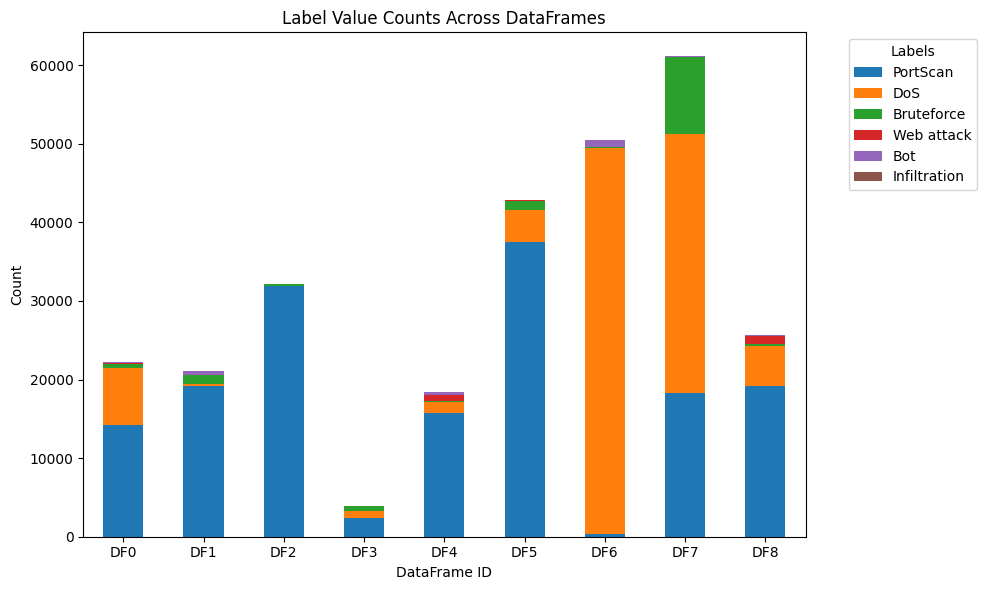

In [20]:
label_counts = []
for i,df in partitions.items():
    counts = df['Label'].value_counts()
    counts.name = f"DF{i}"  # Naming the series for the DataFrame
    label_counts.append(counts)

combined_counts = pd.DataFrame(label_counts).fillna(0)
#combined_counts.columns = [f"DF{i+1}" for i in range(len(partitions))]

# Plot a vertical barplot with x-axis as DataFrame IDs and colors for labels
ax = combined_counts.plot(kind='bar', figsize=(10, 6),stacked = True)
ax.set_title('Label Value Counts Across DataFrames')
ax.set_xlabel('DataFrame ID')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

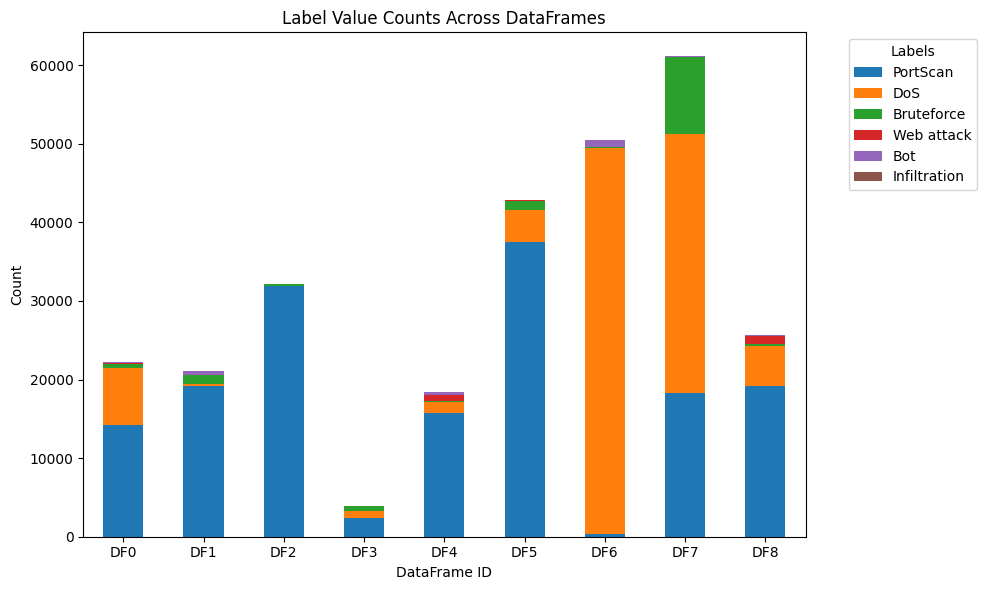

In [ ]:
label_counts = []
for i,df in partitions.items():
    counts = df['Label'].value_counts()
    counts.name = f"DF{i}"  # Naming the series for the DataFrame
    label_counts.append(counts)

combined_counts = pd.DataFrame(label_counts).fillna(0)
#combined_counts.columns = [f"DF{i+1}" for i in range(len(partitions))]

# Plot a vertical barplot with x-axis as DataFrame IDs and colors for labels
ax = combined_counts.plot(kind='bar', figsize=(10, 6),stacked = True)
ax.set_title('Label Value Counts Across DataFrames')
ax.set_xlabel('DataFrame ID')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [22]:
partitions[0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_Binary,Label_Encoded
0,8080,1029368,3,3,0,18,0,0,0.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,Bot,True,1
1,8080,118320,24,38,83617,344,7300,0,3484.041667,2214.770426,...,0.0,0,0,0.0,0.0,0,0,Bot,True,1
2,8080,64603,4,3,207,134,195,0,51.750000,95.541876,...,0.0,0,0,0.0,0.0,0,0,Bot,True,1
3,8080,1013856,3,3,0,18,0,0,0.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,Bot,True,1
4,8080,281794,5,4,214,145,196,0,42.800000,85.680803,...,0.0,0,0,0.0,0.0,0,0,Bot,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22277,80,5365414,3,1,0,0,0,0,0.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,Web attack,True,6
22278,80,5214257,3,1,0,0,0,0,0.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,Web attack,True,6
22279,80,5732160,3,1,0,0,0,0,0.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,Web attack,True,6
22280,80,5469757,3,1,0,0,0,0,0.000000,0.000000,...,0.0,0,0,0.0,0.0,0,0,Web attack,True,6


In [ ]:
pd.DataFrame(label_counts)

Label,Bruteforce,PortScan,DoS,Web attack,Bot,Infiltration
DF1,4439.0,3030.0,2244.0,340.0,262.0,NaN
DF2,257.0,1191.0,2.0,6.0,1051.0,12.0
DF3,3060.0,14917.0,19687.0,59.0,14.0,3.0
DF4,2725.0,115227.0,4930.0,56.0,39.0,NaN
DF5,310.0,20757.0,5166.0,1.0,NaN,8.0
DF6,161.0,10.0,2978.0,1094.0,491.0,1.0
DF7,1714.0,1903.0,1577.0,371.0,75.0,2.0
DF8,1046.0,1327.0,20132.0,216.0,7.0,1.0
DF9,120.0,442.0,44317.0,37.0,17.0,9.0


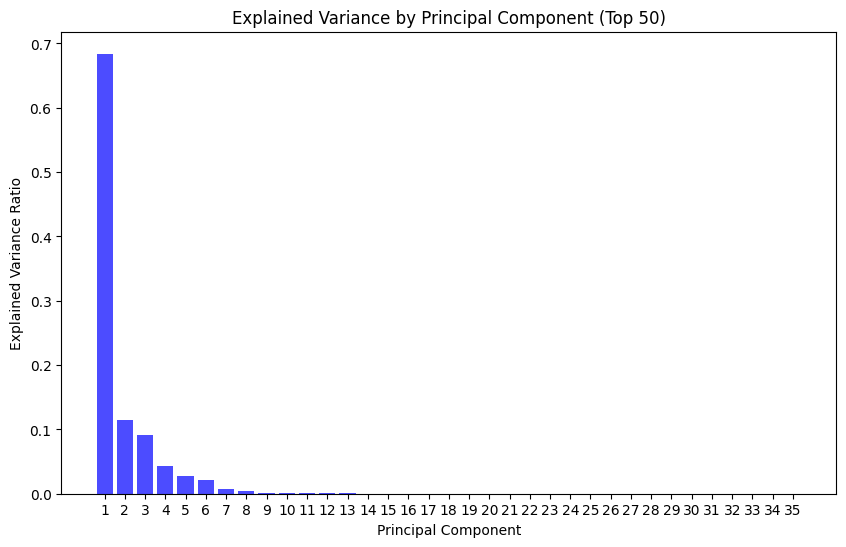

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
X_train = pca.fit_transform(final_df[final_df.columns[:-2]])

explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, 36), explained_variance, alpha=0.7, color='blue', align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component (Top 50)')
plt.xticks(range(1, 36))
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset
from sklearn.decomposition import PCA

NUM_CLIENTS = 9
BATCH_SIZE = 32
ENABLE_PCA = False
np.random.seed(42)
partitions = dirichlet_partition(final_df.loc[final_df['Label_Binary']==1],0.6,9)
## Label Col = 2
def load_datasets(dataset,model_type:str,partition_id: int,partition_type:str,label_col_num = 2):

    Benign = dataset.loc[dataset['Label_Binary']==0]
    partition_benign = Benign.iloc[partition_id*int(len(Benign)/NUM_CLIENTS):(partition_id+1)*int(len(Benign)/NUM_CLIENTS)]
    Attack = dataset.loc[dataset['Label_Binary']==1]
    if partition_type == 'dirichlet':
      partition_attack = partitions[partition_id]
    feature_columns = partition.columns[:-label_col_num]
    partition_train_test = {}
    if model_type == 'Autoencoder':
      partition_train_test['train'] = partition_benign.iloc[:int(0.39*len(partition_benign))-1]
      #print(partition_train_test['train'].index)
      #print(int(0.39*len(partition_benign))-1)
      partition_train_test['val'] = partition_benign.iloc[int(0.39*len(partition_benign)):int(0.78*len(partition_benign))]
      #print(len(partition_train_test['val']))
      #partition_train_test['test_benign'] = pd.concat([partition_benign.iloc[int(0.8*len(partition_benign)):],partition_attack.iloc[:len(partition_benign)]])
      partition_train_test['test_benign'] = partition_benign.iloc[int(0.8*len(partition_benign)):]
      #print(len(partition_train_test['test_benign']))
      partition_train_test['test_attack'] = partition_attack.iloc[:len(partition_benign)]
      #print(len(partition_train_test['test_attack']))
    scaler = MinMaxScaler()
    scaler.fit(partition_train_test['train'][feature_columns])
    X_train = torch.tensor(scaler.transform(partition_train_test['train'][feature_columns]))
    #print(f'train_max:{X_train.max()}')
    y_train = torch.tensor(partition_train_test['train']['Label_Binary'].values)
    if ENABLE_PCA:
      pca = PCA(n_components=35)
      X_train = torch.tensor(pca.fit_transform(X_train.numpy()))
      '''
      explained_variance = pca.explained_variance_ratio_
      plt.figure(figsize=(10, 6))
      plt.bar(range(1, 51), explained_variance, alpha=0.7, color='blue', align='center')
      plt.xlabel('Principal Component')
      plt.ylabel('Explained Variance Ratio')
      plt.title('Explained Variance by Principal Component (Top 50)')
      plt.xticks(range(1, 51))
      plt.show()
      '''

    X_val = torch.tensor(scaler.transform(partition_train_test['val'][feature_columns]))
    y_val = torch.tensor(partition_train_test['val']['Label_Binary'].values)
    if ENABLE_PCA:
      pca = PCA(n_components=35)
      X_val = torch.tensor(pca.fit_transform(X_val.numpy()))
    #print(f'val_max:{X_val.max()}')
    X_test_benign = torch.tensor(scaler.transform(partition_train_test['test_benign'][feature_columns]))
    y_test_benign = torch.tensor(partition_train_test['test_benign']['Label_Binary'].values)
    if ENABLE_PCA:
      pca = PCA(n_components=35)
      X_test_benign = torch.tensor(pca.fit_transform(X_test_benign.numpy()))
    #print(f'benign_max:{X_test_benign.max()}')
    X_test_attack = torch.tensor(scaler.transform(partition_train_test['test_attack'][feature_columns]))
    y_test_attack = torch.tensor(partition_train_test['test_attack']['Label_Binary'].astype(bool).values)
    if ENABLE_PCA:
      pca = PCA(n_components=35)
      X_test_attack = torch.tensor(pca.fit_transform(X_test_attack.numpy()))
    #print(f'attack_max:{X_test_attack.max()}')
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_benign_dataset = TensorDataset(X_test_benign, y_test_benign)
    test_attack_dataset = TensorDataset(X_test_attack, y_test_attack)
    trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    benign_testloader = DataLoader(test_benign_dataset, batch_size=BATCH_SIZE)
    attack_testloader = DataLoader(test_attack_dataset, batch_size=BATCH_SIZE)
    return trainloader, valloader, benign_testloader, attack_testloader

<ipython-input-11-7b43f4fbec64>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  partitions[i] = pd.concat([partitions[i], group.iloc[start:start + count]])


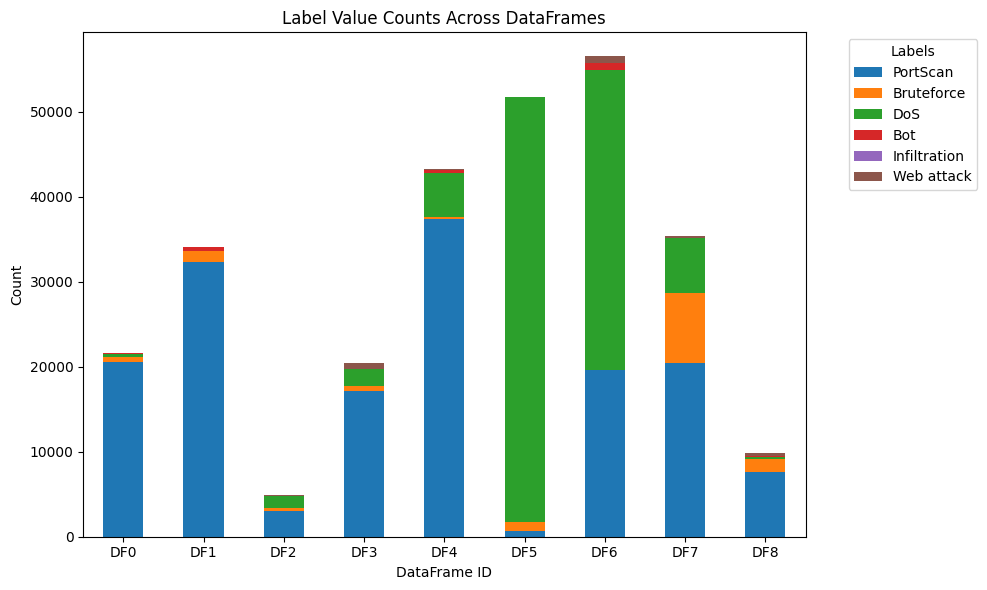

In [ ]:
label_counts = []
for i,df in partitions.items():
    counts = df['Label'].value_counts()
    counts.name = f"DF{i}"  # Naming the series for the DataFrame
    label_counts.append(counts)

combined_counts = pd.DataFrame(label_counts).fillna(0)
#combined_counts.columns = [f"DF{i+1}" for i in range(len(partitions))]

# Plot a vertical barplot with x-axis as DataFrame IDs and colors for labels
ax = combined_counts.plot(kind='bar', figsize=(10, 6),stacked = True)
ax.set_title('Label Value Counts Across DataFrames')
ax.set_xlabel('DataFrame ID')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
trainloader,valloader,benign_testloader,attack_testloader = load_datasets(final_df,'Autoencoder',0,'dirichlet')

In [ ]:
next(iter(trainloader))

[tensor([[8.0967e-04, 1.1083e-06, 4.7600e-06,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.3768e-02, 4.1667e-08, 4.7600e-06,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [8.0967e-04, 3.2089e-04, 4.7600e-06,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [1.2221e-03, 9.7230e-01, 2.2848e-04,  ..., 7.1316e-05, 8.3313e-02,
          8.3193e-02],
         [2.0929e-03, 4.1667e-08, 4.7600e-06,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [3.1999e-01, 1.6820e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]], dtype=torch.float64),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False])]

In [ ]:
final_df['Label'].unique()[1:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['DoS', 'PortScan', 'Bruteforce', 'Bot', 'Web attack',
       'Infiltration'], dtype=object)

In [ ]:
for i in range(9):
  trainloader,valloader,benign_testloader,attack_testloader = load_datasets(final_df,'Autoencoder',i,'dirichlet')
  print(f'client:{i}')
  print(f'train:{len(trainloader.dataset)}')
  print(f'val:{len(valloader.dataset)}')
  print(f'benign_test:{len(benign_testloader.dataset)}')
  print(f'attack_test:{len(attack_testloader.dataset)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



client:0
train:26267
val:26268
benign_test:13471
attack_test:21644
client:1
train:26267
val:26268
benign_test:13471
attack_test:34151
client:2
train:26267
val:26268
benign_test:13471
attack_test:4852
client:3
train:26267
val:26268
benign_test:13471
attack_test:20397
client:4
train:26267
val:26268
benign_test:13471
attack_test:43240
client:5
train:26267
val:26268
benign_test:13471
attack_test:51795
client:6
train:26267
val:26268
benign_test:13471
attack_test:56541
client:7
train:26267
val:26268
benign_test:13471
attack_test:35362
client:8
train:26267
val:26268
benign_test:13471
attack_test:9859


# **Define Model**

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class Autoencoder_4_layers(nn.Module):
    def __init__(self, layer_sizes):
        """
        Initialize the Autoencoder with custom layer sizes.

        Parameters
        ----------
        layer_sizes : list of int
            A list of four integers specifying the number of neurons in each layer.
            Example: [115, 87, 58, 29]
        """
        super(Autoencoder_4_layers, self).__init__()

        # Ensure we have exactly four layers specified
        assert len(layer_sizes) == 4, "layer_sizes should contain exactly four values."

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(True),
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            nn.ReLU(True),
            nn.Linear(layer_sizes[2], layer_sizes[3]),
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(layer_sizes[3], layer_sizes[2]),
            nn.ReLU(True),
            nn.Linear(layer_sizes[2], layer_sizes[1]),
            nn.ReLU(True),
            nn.Linear(layer_sizes[1], layer_sizes[0]),
            nn.Sigmoid()  # Using Sigmoid to keep the output in range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
layer_sizes = [78, 58, 39, 19]
autoencoder = Autoencoder_4_layers(layer_sizes)
print(autoencoder)


Autoencoder_4_layers(
  (encoder): Sequential(
    (0): Linear(in_features=78, out_features=58, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=58, out_features=39, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=39, out_features=19, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=19, out_features=39, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=39, out_features=58, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=58, out_features=78, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
final_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_Binary
0,53,132,2,2,64,96,32,32,32.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
1,2865,4,2,0,12,0,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
2,53,38506,2,2,96,344,48,48,48.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
3,45682,3,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
4,49460,1259,5,1,438,6,319,6,87.600000,131.974619,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884035,443,3970955,6,7,1057,394,517,0,176.166667,249.512658,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
884036,53,261,2,2,64,120,32,32,32.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
884037,53,48199,4,2,180,212,45,45,45.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,False
884038,80,95675737,4,5,408,11595,402,0,102.000000,200.019999,...,0.0,0.0,0,0,95500000.0,0.0,95500000,95500000,DoS,True


In [ ]:
next(iter(trainloader))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[tensor([[8.0879e-04, 4.0367e-04, 1.4515e-05,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.2208e-03, 4.3539e-01, 1.1612e-04,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.2208e-03, 9.6838e-01, 1.2579e-04,  ..., 7.8990e-05, 8.3333e-02,
          8.3316e-02],
         ...,
         [8.0879e-04, 1.9478e-04, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.2208e-03, 4.8231e-02, 9.6765e-06,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [8.0879e-04, 1.8500e-06, 4.8383e-06,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]], dtype=torch.float64),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False])]

# **Define Training Function**

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(net, trainloader, num_epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(num_epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            inputs = batch[0].float()
            has_nan = torch.isnan(inputs).any()
            if has_nan:
              print(f"Contains NaN: {has_nan}")

            # Check for inf values
            has_inf = torch.isinf(inputs).any()
            if has_inf:
              print(f"Contains Inf: {has_inf}")

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = torch.sqrt(criterion(outputs, inputs))
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
        epoch_loss /= len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss.item():.4f}')
    return epoch_loss.item()


def validation(net,valloader):
  criterion = torch.nn.MSELoss(reduction = 'none')
  net.eval()
  total_loss = 0.0
  loss_history = []
  batch_num = 0
  unreducedLoss_list = []
  with torch.no_grad():
    for batch in valloader:
      batch_num += 1
      inputs = batch[0].float()
      has_nan = torch.isnan(inputs).any()
      if has_nan:
        print(f"Contains NaN: {has_nan}")

      # Check for inf values
      has_inf = torch.isinf(inputs).any()
      if has_inf:
        print(f"Contains Inf: {has_inf}")
      outputs = net(inputs)
      # Raw loss with dimension 32*115
      unreducedLoss = criterion(outputs, inputs)
      unreducedLoss_list.append(unreducedLoss)
      # Raw loss reduced by the second dimension, mean of squared difference
      loss = torch.sqrt(unreducedLoss.mean(dim=1))
      '''
      if loss.sum().item() > 288:
        #print(inputs)
        print(batch_num)
        print(outputs)
        print(loss)
      '''
      total_loss += loss.sum().item()
      loss_history.extend(loss.tolist())
  total_loss/=len(valloader.dataset)
  unreducedLoss_array = np.concatenate([tensor.numpy() for tensor in unreducedLoss_list], axis=0)
  return total_loss,loss_history,unreducedLoss_array


def test(net, testloader,threshold):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.MSELoss(reduction = 'none')
    loss_distribution = []
    unreducedLoss_list = []
    net.eval()
    count_exceed_threshold,count_total,total_loss = 0.0,0.0,0.0
    #print(f'total_size:{len(testloader.dataset)}')
    with torch.no_grad():
        for batch in testloader:
            inputs, labels = [t.float() for t in batch]
            has_nan = torch.isnan(inputs).any()
            if has_nan:
              print(f"Contains NaN: {has_nan}")

            # Check for inf values
            has_inf = torch.isinf(inputs).any()
            if has_inf:
              print(f"Contains Inf: {has_inf}")
            outputs = net(inputs.float())
            # Raw loss with dimension 32*115
            unreducedLoss = criterion(outputs, inputs)
            unreducedLoss_list.append(unreducedLoss)
            # Raw loss reduced by the second dimension, mean of squared difference
            loss = torch.sqrt(unreducedLoss.mean(dim=1))
            #print(f'loss_dtype:{loss.dtype}')
            if torch.isinf(loss).any():
              print(inputs.dtype)
              inf_indices = torch.nonzero(torch.isinf(loss), as_tuple=False)
              print(f'index:{inf_indices}')
              print(f'inputs:{inputs[inf_indices]}')
              print(f'outputs:{outputs[inf_indices]}')
              print(f'loss:{loss}')
              for i in inf_indices:
                input,output = inputs[i],outputs[i]
                print(f'dimension:{input.shape}')
                SE = (output-input)**2
                print(f'SE:{SE}')
                inf_index = torch.nonzero(torch.isinf(SE), as_tuple=False)
                print(f'SE_inf_input:{input[:,inf_index]}')
                print(f'SE_inf_output:{output[:,inf_index]}')
                custom_MSE = torch.mean((output-input)**2)
                print(f'MSE:{custom_MSE}')
                print(f'RMSE:{torch.sqrt(custom_MSE)}')
            #print(f'shape of loss:{loss.shape}')
            #print(loss)
            ## find outlier in reconstruction loss from predefined threshold
            if threshold:
              count_exceed_threshold += (loss > threshold).sum().item()
            count_total += len(loss)
            total_loss += loss.sum().item()
            #print(f'total_loss_dtype:{total_loss.type()}')
            #print(loss.tolist())
            #print(f'loss:{loss}')
            #print(f'total_loss:{total_loss}')
            #print(loss.mean())
            loss_distribution.extend(loss.tolist())
            #total_loss += loss.item()
    exceed_threshold_proportion = count_exceed_threshold/count_total
    #print(f'number of loss:{len(loss_history)}')
    print(f'exceed threshold proportion:{exceed_threshold_proportion}')
    print(f'count_total:{count_total}')
    total_loss /= count_total
    unreducedLoss_array = np.concatenate([tensor.numpy() for tensor in unreducedLoss_list], axis=0)
    return total_loss,loss_distribution, exceed_threshold_proportion,unreducedLoss_array

# **Training in Isolation**

In [ ]:
def plot_roc(benign_MSE_history,attack_MSE_history,plot):
  reconstruction_errors = benign_MSE_history+attack_MSE_history  # Combine errors
  labels = [0]*len(benign_MSE_history) + [1]*len(attack_MSE_history)  # 0 for normal, 1 for anomaly

  # Compute ROC Curve
  fpr, tpr, thresholds = roc_curve(labels, reconstruction_errors)
  roc_auc = auc(fpr, tpr)
  print(f'roc_auc:{roc_auc:.4f}')
  # Plot ROC Curve
  if plot == True:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
  return roc_auc

In [ ]:
def plot_barchart(list1,list2,title,variables,labels = [f'Client_{i}' for i in range(9)]):
  bar_width = 0.35
  index = np.arange(len(labels))

  plt.figure(figsize=(10, 6))
  bars1 = plt.bar(index, list1, bar_width, label=variables[0])
  bars2 = plt.bar(index + bar_width, list2, bar_width, label=variables[1])

  plt.xlabel("Categories")
  plt.ylabel("Values")
  plt.title(f"MAD vs OCSVM {title}")
  plt.xticks(index + bar_width / 2, labels)  # Adjust x-ticks to be between the two bars
  plt.legend()
  for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.4g}',
             ha='center', va='bottom')
  for bar in bars2:
      plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.4g}',
              ha='center', va='bottom')

In [ ]:
# with MAD threshold selection
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
def run_test_OCSVM(K,nu,threshold_type = 'STD'):
  client_thresholds = []
  client_fpr = []
  client_fpr_ocsvm = []
  client_tpr = []
  client_tpr_ocsvm = []
  client_roc_auc = []
  for client in range(9):
    trainloader, valloader, benign_testloader,attack_testloader = load_datasets(final_df,'Autoencoder',client,'dirichlet')
    net = Autoencoder(78,39,19)
    #net = Autoencoder_4_layers(layer_sizes)
    #net = Autoencoder_2_layers(35,15)
    print(f'CLIENT:{client}')
    for epoch in range(5):
        train(net, trainloader, 1)
        loss,loss_history, raw_valid_loss = validation(net, valloader)
        loss_history = np.array(loss_history)
        ## find threshold based on median absolute deviation
        if threshold_type == 'MAD':
          RE_MED = np.median(loss_history)
          RE_MAD = np.median(np.abs(loss_history - RE_MED))
          threshold = RE_MED + K*RE_MAD
        ## find threshold based on std
        elif threshold_type == 'STD':
          q1 = np.percentile(loss_history, 25)
          q3 = np.percentile(loss_history, 75)
          iqr = q3 - q1
          lower_bound = q1 - 1.5 * iqr
          upper_bound = q3 + 1.5 * iqr
          loss_history_filtered = loss_history[(loss_history >= lower_bound) & (loss_history <= upper_bound)]
          #print(f'original loss:{len(loss_history)}')
          #print(f'filtered loss:{len(loss_history_filtered)}')
          mean = np.mean(loss_history_filtered)
          std = np.std(loss_history_filtered)
          threshold = mean + K*std
        ## find threshold based on clustering
        # Reshape the data to 2D (K-Means requires a 2D array)
        #values_reshaped = np.array(values).reshape(-1, 1)

        # Specify the number of clusters
        #k = 2  # Adjust this to your desired number of clusters

        # Apply K-Means clustering
        #kmeans = KMeans(n_clusters=k, random_state=42)
        #clusters = kmeans.fit_predict(values_reshaped)

        print(f"Epoch {epoch+1}: validation loss {loss}")
        print(f'threshold:{threshold}')
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(raw_valid_loss)
    pca = PCA(n_components=35)
    pca = pca.fit(data_scaled)
    data_reduced = pca.transform(data_scaled)
    ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    ocsvm.fit(data_reduced)
    client_thresholds.append(threshold)
    benign_MSE, benign_MSE_history,false_positive,raw_benign_loss = test(net, benign_testloader,threshold = threshold)
    #plot_pca_2d(raw_benign_loss)
    attack_MSE, attack_MSE_history,true_positive, raw_attack_loss = test(net, attack_testloader,threshold = threshold)
    #plot_pca_2d(raw_attack_loss)
    raw_benign_loss_scaled = scaler.transform(raw_benign_loss)
    benign_reduced = pca.transform(raw_benign_loss_scaled)
    raw_attack_loss_scaled = scaler.transform(raw_attack_loss)
    attack_reduced = pca.transform(raw_attack_loss_scaled)
    benign_predicts = ocsvm.predict(benign_reduced)
    ocsvm_fpr = (benign_predicts < 0).sum()/len(benign_predicts)
    client_fpr_ocsvm.append(ocsvm_fpr)
    print(f'FPR derived with OCSVM:{ocsvm_fpr}')
    attack_predicts = ocsvm.predict(attack_reduced)
    ocsvm_tpr = (attack_predicts < 0).sum()/len(attack_predicts)
    client_tpr_ocsvm.append(ocsvm_tpr)
    print(f'TPR derived with OCSVM:{ocsvm_tpr}')
    fpr,tpr,tnr,fnr = false_positive,true_positive,1-false_positive,1-true_positive
    client_fpr.append(fpr)
    client_tpr.append(tpr)
    print(f'False Positive Rate:{fpr}')
    print(f'True Positive Rate:{tpr}')
    print(f'benign_error:{benign_MSE}')
    print(f'attack_error:{attack_MSE}')
    roc_auc = plot_roc(benign_MSE_history,attack_MSE_history,plot = False)
    client_roc_auc.append(roc_auc)
  history_MAD = {'thresholds':client_thresholds,'fpr':client_fpr,'tpr':client_tpr,'roc_auc':client_roc_auc}
  history_OCSVM = {'fpr':client_fpr_ocsvm,'tpr':client_tpr_ocsvm}
  plot_barchart(client_fpr,client_fpr_ocsvm,'False Positive Rate',['MAD','OCSVM'])
  plot_barchart(client_tpr,client_tpr_ocsvm,'True Positive Rate',['MAD','OCSVM'])
  return history_MAD,history_OCSVM

CLIENT:0
Epoch [1/1], Train Loss: 0.0973
Epoch 1: validation loss 0.032083933926507255
threshold:0.04613596208144932
Epoch [1/1], Train Loss: 0.0367
Epoch 2: validation loss 0.020305800864744428
threshold:0.03098968633922247
Epoch [1/1], Train Loss: 0.0295
Epoch 3: validation loss 0.016623121326202413
threshold:0.02440635449116818
Epoch [1/1], Train Loss: 0.0269
Epoch 4: validation loss 0.014918541595015294
threshold:0.021367950860424298
Epoch [1/1], Train Loss: 0.0255
Epoch 5: validation loss 0.014702659189356178
threshold:0.02003024562658924
exceed threshold proportion:0.15455422760002968
count_total:13471.0
exceed threshold proportion:0.12114211790796525
count_total:21644.0
FPR derived with OCSVM:0.3018335684062059
TPR derived with OCSVM:0.5085012012566993
False Positive Rate:0.15455422760002968
True Positive Rate:0.12114211790796525
benign_error:0.01418272512220662
attack_error:0.01464906155531584
roc_auc:0.6725
CLIENT:1
Epoch [1/1], Train Loss: 0.1049
Epoch 1: validation loss 0.03

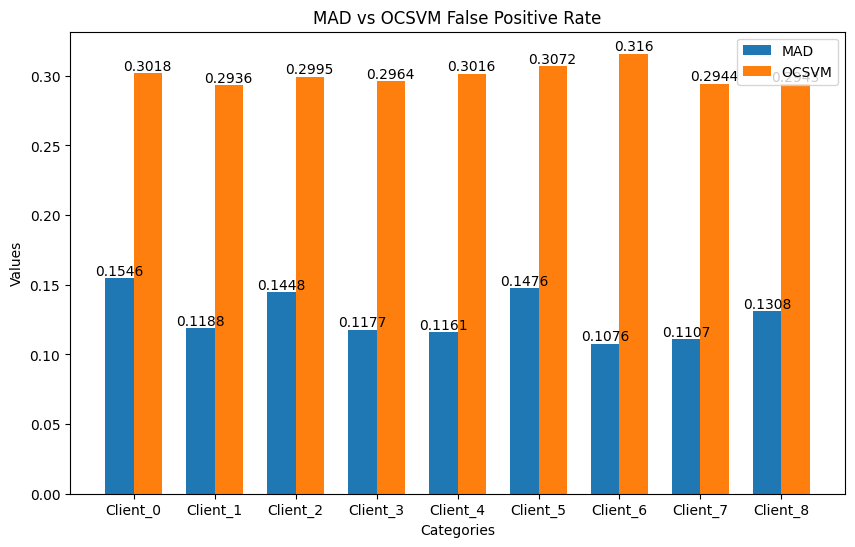

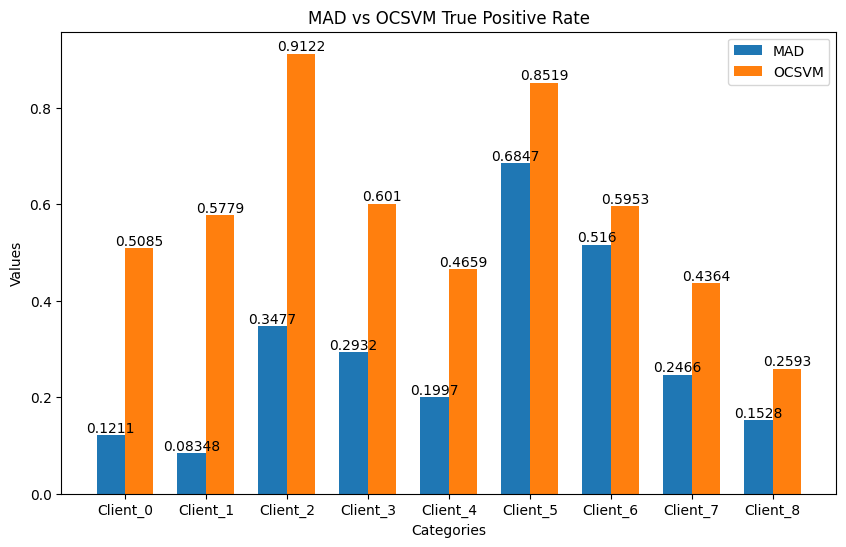

In [ ]:
history_STD,history_OCSVM = run_test_OCSVM(2,0.3,threshold_type='STD')

# **Federated Learning**

## **With Autoencoder**

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [ ]:
## The first step toward creating a ClientApp is to implement a subclasses of flwr.client.Client or flwr.client.NumPyClient.
## We use NumPyClient in this tutorial because it is easier to implement and requires us to write less boilerplate.
class FlowerClient_Train(NumPyClient):
    def __init__(self, net, partition_id,trainloader, valloader, benign_testloader, attack_testloader,context:Context):
        self.client_state = (
            context.state
        )
        #if "eval_metrics" not in self.client_state.configs_records:
            #.client_state.configs_records["eval_metrics"] = ConfigsRecord()
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.benign_testloader = benign_testloader
        self.attack_testloader = attack_testloader
        self.partition_id = partition_id
        #print(self.client_state.configs_records)

    def get_parameters(self, config):
        return get_parameters(self.net)
    ## Training
    def fit(self, parameters, config):
      print(f"[Client {self.partition_id}] fit, config: {config}")
      set_parameters(self.net, parameters)
      #eval_metrics = self.client_state.configs_records["eval_metrics"]
      local_epoch = 4
      '''
      if 'local_epoch' not in eval_metrics:
        local_epoch = 4
        eval_metrics["local_epoch"] = [4]
      else:
        local_epoch = eval_metrics['local_epoch'][-1]
      '''
      loss = train(self.net, self.trainloader, num_epochs=local_epoch)
      return get_parameters(self.net), len(self.trainloader), {'train_loss':loss,'config':local_epoch}
    ## Validation on subset of benign data to select threshold
    def evaluate(self, parameters, config):
      print(f"[Client {self.partition_id}] evaluate, config: {config}")
      set_parameters(self.net, parameters)
      loss,val_loss_history,valid_unreduced_loss = validation(self.net,self.valloader)
      val_loss_history = np.array(val_loss_history)
      ## calculate threshold based on MAD to make it more robust to outliers in normal data
      '''
      median = np.median(val_loss_history)
      MAD = np.median(np.abs(val_loss_history - median))
      threshold = median +10*MAD
      '''
      ## calculate threshold based on standard deviation after filtering out the outliers with IQR
      q1 = np.percentile(val_loss_history, 25)
      q3 = np.percentile(val_loss_history, 75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr
      val_loss_history_filtered = val_loss_history[(val_loss_history >= lower_bound) & (val_loss_history <= upper_bound)]
      #print(f'original loss:{len(loss_history)}')
      #print(f'filtered loss:{len(loss_history_filtered)}')
      mean = np.mean(val_loss_history_filtered)
      std = np.std(val_loss_history_filtered)
      threshold = mean + 2*std
      '''
      # train a linear one class SVM to find anomalous data
      svm = OneClassSVM(kernel='linear', nu=0.5)
      svm.fit(val_loss_history_filtered.reshape(-1, 1))
      #outlier_scores = svm.decision_function(val_loss_history.reshape(-1, 1))
      # save the one-class svm model fit on the local validation set
      joblib.dump(svm, f'svm_model_{self.partition_id}.pkl')
      # train an isolation forest to find anomalous data
      #model = IsolationForest(contamination=0.1, random_state=42)

      eval_metrics = self.client_state.configs_records["eval_metrics"]
      if 'local_epoch' not in eval_metrics:
        eval_metrics["local_epoch"] = [4]
      if "threshold" not in eval_metrics:
        eval_metrics["threshold"] = [threshold]
      else:
        eval_metrics["threshold"].append(threshold)
      if threshold > eval_metrics['threshold'][-1]:
        eval_metrics['local_epoch'].append(8)
      else:
        eval_metrics['local_epoch'].append(4)
      print(f'mean_valid_loss:{np.mean(val_loss_history)}')
      '''
      return float(loss), len(self.valloader), {'Client':self.partition_id,'validation_loss':loss,'validation_threshold':threshold}

In [ ]:
def client_fn_train(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    #net = Autoencoder(115,58,29).to(DEVICE)
    net = Autoencoder(78,39,19)
    #net = Autoencoder_4_layers(layer_sizes)
    #net = Autoencoder_2_layers(35,15)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    # The value of partition-id is retrieved from the node_config dictionary in the Context object, which holds the information that persists throughout each training round.
    partition_id = int(context.node_config["partition-id"])
    trainloader, valloader, benign_testloader,attack_testloader = load_datasets(final_df,'Autoencoder',partition_id,'dirichlet')

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient_Train(net, partition_id,trainloader, valloader,benign_testloader,attack_testloader,context).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn_train)

In [ ]:
## Select the max loss from validation dataset as the threshold
def max_loss(metrics: List[Tuple[int, Metrics]]) -> Metrics:
  client_valid_loss = [m['validation_loss'] for _,m in metrics]
  print(client_valid_loss)
  client_max_loss = client_valid_loss.index(max(client_valid_loss))
  return {'max_loss':max(client_valid_loss),'client_max_loss':client_max_loss}

In [ ]:
def threshold_selection(metrics: List[Tuple[int, Metrics]]) -> Metrics:
  client_valid_threshold = [m['validation_threshold'] for _,m in metrics]
  client_id = [m['Client'] for _,m in metrics]
  for id,threshold in zip(client_id,client_valid_threshold):
    print(f'Client {id} threshold: {threshold}')
  sorted_data = sorted(zip(client_id, client_valid_threshold), key=lambda x: x[0])
  sorted_client_id, sorted_client_valid_threshold = zip(*sorted_data)
  aggregate_threshold_mean = np.mean(client_valid_threshold)
  aggregate_threshold_std = np.std(client_valid_threshold)
  return {'aggregate_threshold_mean':aggregate_threshold_mean,'aggregate_threshold_std':aggregate_threshold_std,'client_thresholds':sorted_client_valid_threshold}

In [ ]:
## Return average training loss
def average_loss(metrics: List[Tuple[int, Metrics]]) -> Metrics:
  client_train_loss = [m['train_loss'] for num_examples,m in metrics]
  client_config = [m['config'] for num_examples,m in metrics]
  print(client_train_loss)
  print(client_config)
  return {'train_loss':sum(client_train_loss)/len(client_train_loss)}

In [ ]:
global_model_trained = Autoencoder(78,39,19)

In [ ]:
from typing import Union, Optional, Dict
from flwr.server.client_proxy import ClientProxy
from flwr.common import FitRes,Parameters, FitIns, EvaluateRes
from flwr.server.client_manager import ClientManager
from flwr.server.strategy import FedAdam

class SaveModelStrategy(FedAdam):
    def __init__(self,
                 *,
                 patience:int,
                 **kwargs):
       super().__init__(**kwargs)
       self.best_eval_thres = float('inf')
       self.server_rounds_without_improvement = 0
       self.patience = patience
       self.current_model_params = None
       self.update_params = False
       self.previous_client_threshold = {key: None for key in range(9)}
       self.client_update_lst = []

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[flwr.server.client_proxy.ClientProxy, flwr.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        if aggregated_parameters is not None:
          aggregated_ndarrays: List[np.ndarray] = flwr.common.parameters_to_ndarrays(
                aggregated_parameters
            )
          self.current_model_params = aggregated_ndarrays

        return aggregated_parameters, aggregated_metrics

    def aggregate_evaluate(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, EvaluateRes]],
        failures: list[Union[tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> tuple[Optional[float], dict[str, Scalar]]:

        loss_aggregated, metrics_aggregated = super().aggregate_evaluate(server_round, results, failures)
        # Get current highest threshold on the client-side validation set
        current_eval_thres = metrics_aggregated['aggregate_threshold_mean']

        client_thresholds = metrics_aggregated['client_thresholds']
        self.client_update_lst = []
        for i in range(len(client_thresholds)):
          if self.previous_client_threshold[i] is not None:
            if client_thresholds[i] > self.previous_client_threshold[i]:
              self.client_update_lst.append(i)
          self.previous_client_threshold[i] = client_thresholds[i]
        #print(self.client_update_lst)

        if current_eval_thres < self.best_eval_thres:
          self.server_rounds_without_improvement = 0
          # Update the best threshold
          self.best_eval_thres = current_eval_thres
          self.update_params = True
          print('Lowest validation threshold updated')
          # Save the model if the threshold is the lowest
          params_dict = zip(global_model_trained.state_dict().keys(), self.current_model_params)
          state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
          global_model_trained.load_state_dict(state_dict, strict=True)
          print(f'Saving model at round {server_round}')
          torch.save(global_model_trained.state_dict(), f"model_round_{server_round}.pth")
        else:
          self.server_rounds_without_improvement += 1
          self.update_parms = False
          print(f"No improvement in validation loss for {self.server_rounds_without_improvement} round(s)")
        if self.server_rounds_without_improvement >= self.patience:
          print(f"Early stopping triggered at round {server_round}")

        return loss_aggregated, metrics_aggregated







In [ ]:
state_dict_ndarrays = [v.cpu().numpy() for v in global_model_trained.state_dict().values()]
initial_parameters = flwr.common.ndarrays_to_parameters(state_dict_ndarrays)

In [ ]:
NUM_CLIENTS = 9

In [ ]:
strategy = SaveModelStrategy(
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=1,
        min_evaluate_clients=1,
        min_available_clients=7,
        initial_parameters = initial_parameters,
        evaluate_metrics_aggregation_fn=threshold_selection,  # <-- pass the metric aggregation function, return the max loss in each validation round
        fit_metrics_aggregation_fn=average_loss,
        patience = 15,
        eta = 0.0008,
        eta_l = 0.001
        #**best_params
    )

history_train = flwr.simulation.start_simulation(
        client_fn=client_fn_train,  # a function that spawns a particular client
        num_clients=NUM_CLIENTS,  # total number of clients
        config=flwr.server.ServerConfig(
            num_rounds=50
        ),  # minimal config for the server loop telling the number of rounds in FL
        strategy=strategy,  # our strategy of choice
        client_resources={
            "num_cpus": 1,
            "num_gpus": 0.0,
        },  # (optional) controls the degree of parallelism of your simulation.
        # Lower resources per client allow for more clients to run concurrently
        # (but need to be set taking into account the compute/memory footprint of your run)
        # `num_cpus` is an absolute number (integer) indicating the number of threads a client should be allocated
        # `num_gpus` is a ratio indicating the portion of gpu memory that a client needs.
    )

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2025-01-18 11:38:48,039	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resource

(ClientAppActor pid=79331) [Client 2] fit, config: {}
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.1010
(ClientAppActor pid=79326) [Client 5] fit, config: {} [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=79331) Epoch [3/4], Train Loss: 0.0303 [repeated 19x across cluster]
(ClientAppActor pid=79334) [Client 8] fit, config: {}
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0267 [repeated 15x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.025884876027703285, 0.021163873374462128, 0.01937904581427574, 0.026330675929784775, 0.027723567560315132, 0.020921463146805763, 0.018477384001016617, 0.023538874462246895, 0.021422671154141426]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 6] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0235
(ClientAppActor pid=79334) [Client 8] evaluate, config: {} [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 3 threshold: 0.5041033249896942
Client 1 threshold: 0.4983966164895191
Client 0 threshold: 0.5021643141481833
Client 6 threshold: 0.49672364846337114
Client 8 threshold: 0.49858054605698504
Client 2 threshold: 0.5016073825566856
Client 5 threshold: 0.4978982127120134
Client 7 threshold: 0.5025359815423992
Client 4 threshold: 0.5032883978363013
Lowest validation threshold updated
Saving model at round 1
(ClientAppActor pid=79334) [Client 5] fit, config: {}
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.1007
(ClientAppActor pid=79326) [Client 0] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [2/4], Train Loss: 0.0346 [repeated 15x across cluster]
(ClientAppActor pid=79334) [Client 1] fit, config: {}
(ClientAppActor pid=79334) Epoch [2/4], Train Loss: 0.0342 [repeated 17x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.018017057329416275, 0.02390868403017521, 0.024215485900640488, 0.021008705720305443, 0.02535625360906124, 0.026568569242954254, 0.02886193059384823, 0.026793058961629868, 0.024425087496638298]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 8] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0210 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.4962823640862828
Client 1 threshold: 0.4979340065816145
Client 7 threshold: 0.5021375633864908
Client 0 threshold: 0.5017707378456728
Client 4 threshold: 0.5028400782337933
Client 3 threshold: 0.5036206591902898
Client 2 threshold: 0.5011641065725009
Client 8 threshold: 0.49813647572376857
Client 5 threshold: 0.49745083653517963
Lowest validation threshold updated
Saving model at round 2
(ClientAppActor pid=79334) [Client 5] fit, config: {}
(ClientAppActor pid=79334) [Client 7] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0966 [repeated 2x across cluster]
(ClientAppActor pid=79326) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0259 [repeated 16x across cluster]
(ClientAppActor pid=79334) [Client 4] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.023072410374879837, 0.026149624958634377, 0.02119816280901432, 0.02087477408349514, 0.019284818321466446, 0.021231694146990776, 0.01912214607000351, 0.017694858834147453, 0.025937650352716446]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0212 [repeated 18x across cluster]
(ClientAppActor pid=79334) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.49580724992478004
Client 1 threshold: 0.4974452007411129
Client 7 threshold: 0.5017143998201482
Client 2 threshold: 0.5006853819805565
Client 0 threshold: 0.5013376812012131
Client 4 threshold: 0.5023468762123503
Client 3 threshold: 0.5031303598899711
Client 8 threshold: 0.49764129717272004
Client 5 threshold: 0.4969591959009288
Lowest validation threshold updated
Saving model at round 3
(ClientAppActor pid=79334) [Client 4] fit, config: {}
(ClientAppActor pid=79334) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.1039
(ClientAppActor pid=79328) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0281 [repeated 13x across cluster]
(ClientAppActor pid=79334) [Client 5] fit, config: {}
(ClientAppActor pid=79334) Epoch [2/4], Train Loss: 0.0335 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.017372002825140953, 0.025447903200984, 0.02123616635799408, 0.0205297339707613, 0.018101191148161888, 0.02397671528160572, 0.02180439792573452, 0.02217133715748787, 0.018701601773500443]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 0] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0187 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 5 threshold: 0.4964483142991003
Client 2 threshold: 0.5001839502352943
Client 6 threshold: 0.4952984672849842
Client 4 threshold: 0.501828924957644
Client 7 threshold: 0.5012591291312696
Client 0 threshold: 0.5008809994424888
Client 8 threshold: 0.4971290878035571
Client 3 threshold: 0.5026184657463223
Client 1 threshold: 0.4969298709413382
Lowest validation threshold updated
Saving model at round 4
(ClientAppActor pid=79334) [Client 3] fit, config: {}
(ClientAppActor pid=79334) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.1044
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.1046
(ClientAppActor pid=79328) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0176 [repeated 16x across cluster]
(ClientAppActor pid=79334) [Client 7] fit, config: {}
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0293 [repeated 17x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.017586616799235344, 0.022895710542798042, 0.016444476321339607, 0.02411535196006298, 0.02187686786055565, 0.019179239869117737, 0.02616097591817379, 0.01926499418914318, 0.025178536772727966]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 0] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0262


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.49640036500539186
Client 7 threshold: 0.5007868471690017
Client 5 threshold: 0.49591559969203497
Client 4 threshold: 0.501286762913062
Client 2 threshold: 0.4996566637865553
Client 6 threshold: 0.49477686935760584
Client 8 threshold: 0.49659882214460677
Client 3 threshold: 0.5020715466874942
Client 0 threshold: 0.5003973164288094
Lowest validation threshold updated
Saving model at round 5
(ClientAppActor pid=79334) [Client 8] fit, config: {}
(ClientAppActor pid=79334) [Client 8] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0999
(ClientAppActor pid=79328) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0255 [repeated 15x across cluster]
(ClientAppActor pid=79334) [Client 1] fit, config: {}
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0277 [repeated 19x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.026085715740919113, 0.02154264785349369, 0.017696654424071312, 0.02027350291609764, 0.020141705870628357, 0.02850555256009102, 0.023252099752426147, 0.022904301062226295, 0.018486734479665756]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 1] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0203


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 8 threshold: 0.49604022123072694
Client 6 threshold: 0.494227958220634
Client 0 threshold: 0.49989210799744904
Client 5 threshold: 0.49537308778984623
Client 7 threshold: 0.5002978531437235
Client 3 threshold: 0.5015104412737925
Client 2 threshold: 0.4991014972013225
Client 4 threshold: 0.5007241298943275
Client 1 threshold: 0.4958539705485141
Lowest validation threshold updated
Saving model at round 6
(ClientAppActor pid=79334) [Client 7] fit, config: {}
(ClientAppActor pid=79334) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0936
(ClientAppActor pid=79328) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [2/4], Train Loss: 0.0360 [repeated 16x across cluster]
(ClientAppActor pid=79334) [Client 1] fit, config: {}
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0256 [repeated 18x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.01835806481540203, 0.028186997398734093, 0.018382631242275238, 0.01704283058643341, 0.026084797456860542, 0.019023578613996506, 0.02152344211935997, 0.01885373145341873, 0.018163049593567848]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 2] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0189


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 4 threshold: 0.5001354194013791
Client 7 threshold: 0.49979222197704465
Client 8 threshold: 0.4954646295954892
Client 6 threshold: 0.49364668475430623
Client 3 threshold: 0.5009237374534492
Client 0 threshold: 0.49937765153169045
Client 1 threshold: 0.4952717329601529
Client 2 threshold: 0.4985312147303881
Client 5 threshold: 0.49480574716227876
Lowest validation threshold updated
Saving model at round 7
(ClientAppActor pid=79334) [Client 7] fit, config: {}
(ClientAppActor pid=79334) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0925
(ClientAppActor pid=79328) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79328) Epoch [1/4], Train Loss: 0.1028 [repeated 13x across cluster]
(ClientAppActor pid=79334) [Client 8] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.01862187497317791, 0.02481253072619438, 0.0183641966432333, 0.018557067960500717, 0.02047405205667019, 0.017928143963217735, 0.019820978865027428, 0.024282433092594147, 0.024715827777981758]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0186 [repeated 22x across cluster]
(ClientAppActor pid=79334) [Client 8] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.49885009548478454
Client 5 threshold: 0.4942159987681167
Client 1 threshold: 0.49467325122714806
Client 6 threshold: 0.49306056381585267
Client 4 threshold: 0.4995380859968532
Client 2 threshold: 0.4979445565492973
Client 7 threshold: 0.499280961691416
Client 3 threshold: 0.5003212328303686
Client 8 threshold: 0.4948784403148202
Lowest validation threshold updated
Saving model at round 8
(ClientAppActor pid=79334) [Client 6] fit, config: {}
(ClientAppActor pid=79334) [Client 6] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0967
(ClientAppActor pid=79328) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0287 [repeated 13x across cluster]
(ClientAppActor pid=79334) [Client 8] fit, config: {}
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0267 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.024438532069325447, 0.017894664779305458, 0.017615554854273796, 0.019137505441904068, 0.020087409764528275, 0.024872031062841415, 0.02518923394382, 0.0222738366574049, 0.021968407556414604]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 6] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0220


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.4982975561706223
Client 5 threshold: 0.4935935879549075
Client 1 threshold: 0.4940670709943903
Client 2 threshold: 0.4973361851195202
Client 8 threshold: 0.4942750425872973
Client 7 threshold: 0.4987345915956345
Client 4 threshold: 0.49890191819856483
Client 3 threshold: 0.4996942058230457
Client 6 threshold: 0.49245919936009785
Lowest validation threshold updated
Saving model at round 9
(ClientAppActor pid=79326) [Client 3] fit, config: {}
(ClientAppActor pid=79326) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.1003
(ClientAppActor pid=79333) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [1/4], Train Loss: 0.0966 [repeated 14x across cluster]
(ClientAppActor pid=79326) [Client 0] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0286 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.0263051874935627, 0.019424736499786377, 0.025666899979114532, 0.026673512533307076, 0.0191932525485754, 0.018860764801502228, 0.03160708025097847, 0.01744801364839077, 0.02266795188188553]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 2] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0263


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.49182977631979186
Client 2 threshold: 0.49671171325215474
Client 0 threshold: 0.497724201267849
Client 4 threshold: 0.49826395540382074
Client 8 threshold: 0.49365218481078854
Client 5 threshold: 0.49296350659169774
Client 3 threshold: 0.4990566219063946
Client 1 threshold: 0.49343584639371596
Client 7 threshold: 0.4981777337916754
Lowest validation threshold updated
Saving model at round 10
(ClientAppActor pid=79326) [Client 8] fit, config: {}
(ClientAppActor pid=79326) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0967
(ClientAppActor pid=79333) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [3/4], Train Loss: 0.0291 [repeated 13x across cluster]
(ClientAppActor pid=79326) [Client 2] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0289 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.026177089661359787, 0.023903798311948776, 0.018875297158956528, 0.020989764481782913, 0.026124797761440277, 0.02610570192337036, 0.018788674846291542, 0.022695304825901985, 0.023263772949576378]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 8] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0210


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.4911750818372373
Client 4 threshold: 0.4976204542183142
Client 8 threshold: 0.4930007654834723
Client 7 threshold: 0.4976043532633233
Client 0 threshold: 0.4971305733170543
Client 3 threshold: 0.49840040232688504
Client 2 threshold: 0.49606620921937006
Client 1 threshold: 0.49277845786465385
Client 5 threshold: 0.492304338232814
Lowest validation threshold updated
Saving model at round 11
(ClientAppActor pid=79326) [Client 2] fit, config: {}
(ClientAppActor pid=79326) [Client 1] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0986
(ClientAppActor pid=79333) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0235 [repeated 12x across cluster]
(ClientAppActor pid=79326) [Client 1] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0281 [repeated 22x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.026841681450605392, 0.02756873145699501, 0.025922438129782677, 0.018851039931178093, 0.025971829891204834, 0.026210736483335495, 0.028205767273902893, 0.018895499408245087, 0.027085766196250916]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 3] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0259


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 3 threshold: 0.49772514569756066
Client 0 threshold: 0.49652912235441277
Client 7 threshold: 0.49701227263360725
Client 4 threshold: 0.49695079159732164
Client 6 threshold: 0.49050037721842893
Client 5 threshold: 0.4916396710512792
Client 8 threshold: 0.4923171827186435
Client 1 threshold: 0.4921005927217389
Client 2 threshold: 0.4954053178878105
Lowest validation threshold updated
Saving model at round 12
(ClientAppActor pid=79326) [Client 6] fit, config: {}
(ClientAppActor pid=79326) [Client 7] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0967
(ClientAppActor pid=79328) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [2/4], Train Loss: 0.0344 [repeated 16x across cluster]
(ClientAppActor pid=79326) [Client 5] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0312 [repeated 18x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.027337025851011276, 0.02682444453239441, 0.027094222605228424, 0.025990614667534828, 0.027593854814767838, 0.019536133855581284, 0.02299507148563862, 0.026269162073731422, 0.02777359075844288]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 8] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0278


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 8 threshold: 0.49162518491462825
Client 3 threshold: 0.49703793449324496
Client 4 threshold: 0.49626082341315214
Client 0 threshold: 0.49590508606942824
Client 7 threshold: 0.4963946846793757
Client 2 threshold: 0.4947233520103166
Client 1 threshold: 0.49138893402014916
Client 5 threshold: 0.49095722467057273
Client 6 threshold: 0.48980950886738345
Lowest validation threshold updated
Saving model at round 13
(ClientAppActor pid=79326) [Client 1] fit, config: {}
(ClientAppActor pid=79326) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0955
(ClientAppActor pid=79328) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79332) Epoch [2/4], Train Loss: 0.0352 [repeated 13x across cluster]
(ClientAppActor pid=79326) [Client 2] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0341 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02687392570078373, 0.026697741821408272, 0.027447393164038658, 0.026342563331127167, 0.02239035815000534, 0.026581816375255585, 0.026959920302033424, 0.01939990371465683, 0.02746010571718216]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 3] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0274


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.48909599654848257
Client 2 threshold: 0.49401922645185514
Client 0 threshold: 0.4952654874827826
Client 5 threshold: 0.49026108175835853
Client 3 threshold: 0.496329018260438
Client 4 threshold: 0.49555374126536184
Client 7 threshold: 0.49576128929280505
Client 1 threshold: 0.4906877736719966
Client 8 threshold: 0.4909180870121682
Lowest validation threshold updated
Saving model at round 14
(ClientAppActor pid=79326) [Client 6] fit, config: {}
(ClientAppActor pid=79326) [Client 4] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0962
(ClientAppActor pid=79328) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79329) Epoch [2/4], Train Loss: 0.0332 [repeated 14x across cluster]
(ClientAppActor pid=79326) [Client 7] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0284 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.027294443920254707, 0.0243360735476017, 0.026257408782839775, 0.02710038796067238, 0.026754112914204597, 0.022875044494867325, 0.019250476732850075, 0.02785753458738327, 0.026000581681728363]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 0] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0268


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.4899582901533723
Client 2 threshold: 0.49330466134195233
Client 5 threshold: 0.48953171439791776
Client 7 threshold: 0.49510703281038904
Client 4 threshold: 0.49484179668522477
Client 6 threshold: 0.48836135106157275
Client 8 threshold: 0.49018232769613185
Client 3 threshold: 0.49559476195113983
Client 0 threshold: 0.4946041263102958
Lowest validation threshold updated
Saving model at round 15
(ClientAppActor pid=79326) [Client 7] fit, config: {}
(ClientAppActor pid=79326) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0880
(ClientAppActor pid=79328) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79329) Epoch [2/4], Train Loss: 0.0366 [repeated 13x across cluster]
(ClientAppActor pid=79326) [Client 3] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0238 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.027331354096531868, 0.02731507457792759, 0.022478338330984116, 0.02627514861524105, 0.026893870905041695, 0.026849467307329178, 0.018623176962137222, 0.026706838980317116, 0.026347290724515915]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 7] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0186


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 5 threshold: 0.48876688213738656
Client 4 threshold: 0.49409800647696117
Client 8 threshold: 0.48942317774978483
Client 2 threshold: 0.49255322316869893
Client 1 threshold: 0.4892018839842866
Client 3 threshold: 0.49484685070772855
Client 0 threshold: 0.49389836941977777
Client 7 threshold: 0.4944289642350891
Client 6 threshold: 0.4876141274221285
Lowest validation threshold updated
Saving model at round 16
(ClientAppActor pid=79330) [Client 7] fit, config: {}
(ClientAppActor pid=79330) [Client 6] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0874
(ClientAppActor pid=79328) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0943 [repeated 13x across cluster]
(ClientAppActor pid=79330) [Client 1] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02500256523489952, 0.021745525300502777, 0.02522682212293148, 0.021363047882914543, 0.02652290090918541, 0.027290597558021545, 0.028475049883127213, 0.027490532025694847, 0.02042957954108715]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0275 [repeated 22x across cluster]
(ClientAppActor pid=79330) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.4931873344217826
Client 4 threshold: 0.49334402942886085
Client 8 threshold: 0.4886476194794328
Client 2 threshold: 0.4918099295622401
Client 5 threshold: 0.4879906745684271
Client 6 threshold: 0.48683017978161075
Client 7 threshold: 0.493741010697639
Client 3 threshold: 0.49408481657274694
Client 1 threshold: 0.48843528920758245
Lowest validation threshold updated
Saving model at round 17
(ClientAppActor pid=79330) [Client 4] fit, config: {}
(ClientAppActor pid=79330) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0934
(ClientAppActor pid=79332) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [2/4], Train Loss: 0.0351 [repeated 14x across cluster]
(ClientAppActor pid=79330) [Client 7] fit, config: {}
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0283 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02703838050365448, 0.02266041934490204, 0.026518359780311584, 0.023210277780890465, 0.027175264433026314, 0.020545292645692825, 0.02105352282524109, 0.026355238631367683, 0.026795318350195885]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79330) [Client 3] evaluate, config: {}
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0265


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.49243371127759966
Client 1 threshold: 0.48763298835992236
Client 6 threshold: 0.48602831984456973
Client 5 threshold: 0.4871917596630363
Client 8 threshold: 0.48787033868279345
Client 7 threshold: 0.4930323107736972
Client 3 threshold: 0.4932929959444261
Client 2 threshold: 0.4910422100851362
Client 4 threshold: 0.49255904731545225
Lowest validation threshold updated
Saving model at round 18
(ClientAppActor pid=79330) [Client 0] fit, config: {}
(ClientAppActor pid=79330) [Client 6] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0830
(ClientAppActor pid=79334) [Client 1] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0211 [repeated 15x across cluster]
(ClientAppActor pid=79330) [Client 7] fit, config: {}
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0283 [repeated 19x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.027484068647027016, 0.027492022141814232, 0.021037274971604347, 0.02065194770693779, 0.026498334482312202, 0.02105770818889141, 0.027369607239961624, 0.021260596811771393, 0.027487879619002342]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79330) [Client 3] evaluate, config: {}
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0265


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.4852179787325768
Client 1 threshold: 0.4867948805075281
Client 7 threshold: 0.4922991269745337
Client 8 threshold: 0.4870494674297025
Client 5 threshold: 0.48636812790223366
Client 3 threshold: 0.4924874857845237
Client 2 threshold: 0.49025296973565263
Client 0 threshold: 0.49168739108411336
Client 4 threshold: 0.4917756150298396
Lowest validation threshold updated
Saving model at round 19
(ClientAppActor pid=79330) [Client 0] fit, config: {}
(ClientAppActor pid=79330) [Client 2] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0833
(ClientAppActor pid=79328) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79328) Epoch [1/4], Train Loss: 0.0921 [repeated 14x across cluster]
(ClientAppActor pid=79330) [Client 5] fit, config: {}
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0300 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.026696709915995598, 0.02719590812921524, 0.026408595964312553, 0.021999217569828033, 0.02161588706076145, 0.02021998167037964, 0.02726179175078869, 0.027598978951573372, 0.021090909838676453]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79330) [Client 1] evaluate, config: {}
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0272


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 2 threshold: 0.48944589811796246
Client 3 threshold: 0.4916392432662036
Client 5 threshold: 0.4855093963315226
Client 6 threshold: 0.4843609252215456
Client 4 threshold: 0.490975528973108
Client 1 threshold: 0.4859683925829394
Client 0 threshold: 0.4909030914263045
Client 8 threshold: 0.48622079851379224
Client 7 threshold: 0.49153333481437905
Lowest validation threshold updated
Saving model at round 20
(ClientAppActor pid=79330) [Client 3] fit, config: {}
(ClientAppActor pid=79330) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0925
(ClientAppActor pid=79328) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0832 [repeated 12x across cluster]
(ClientAppActor pid=79330) [Client 2] fit, config: {}
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0257 [repeated 22x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02707531861960888, 0.023897189646959305, 0.02171248570084572, 0.022841662168502808, 0.027145124971866608, 0.026999205350875854, 0.026715941727161407, 0.026752257719635963, 0.02249586023390293]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79330) [Client 3] evaluate, config: {}
(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0225


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 2 threshold: 0.48861502114272376
Client 4 threshold: 0.4901834965062563
Client 6 threshold: 0.48349529567408756
Client 1 threshold: 0.48510482078108486
Client 7 threshold: 0.4907333102709135
Client 8 threshold: 0.4853576315415355
Client 5 threshold: 0.4846419848550249
Client 0 threshold: 0.4900245653429589
Client 3 threshold: 0.4908175649564334
Lowest validation threshold updated
Saving model at round 21
(ClientAppActor pid=79330) [Client 4] fit, config: {}
(ClientAppActor pid=79330) [Client 6] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0912
(ClientAppActor pid=79328) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [2/4], Train Loss: 0.0324 [repeated 17x across cluster]
(ClientAppActor pid=79330) [Client 6] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


(ClientAppActor pid=79330) Epoch [4/4], Train Loss: 0.0271 [repeated 18x across cluster]
[0.017650919035077095, 0.022006453946232796, 0.027125243097543716, 0.022453131154179573, 0.02708757296204567, 0.026948420330882072, 0.021534837782382965, 0.026384184136986732, 0.023086601868271828]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79330) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 4 threshold: 0.4893312880094248
Client 8 threshold: 0.48447280698908607
Client 6 threshold: 0.4826139042805348
Client 3 threshold: 0.4900006205147856
Client 2 threshold: 0.487776475747716
Client 5 threshold: 0.4837500971847405
Client 0 threshold: 0.48914214507116266
Client 7 threshold: 0.48986604318126215
Client 1 threshold: 0.48421100321365507
Lowest validation threshold updated
Saving model at round 22
(ClientAppActor pid=79331) [Client 4] fit, config: {}
(ClientAppActor pid=79331) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0907
(ClientAppActor pid=79328) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [3/4], Train Loss: 0.0295 [repeated 13x across cluster]
(ClientAppActor pid=79331) [Client 6] fit, config: {}
(ClientAppActor pid=79331) Epoch [3/4], Train Loss: 0.0296 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021900536492466927, 0.025469506159424782, 0.02114943414926529, 0.021053867414593697, 0.022468406707048416, 0.02199680358171463, 0.02274259552359581, 0.025871148332953453, 0.023131035268306732]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) [Client 7] evaluate, config: {}
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0231


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.48332752465471834
Client 4 threshold: 0.48847525900773464
Client 3 threshold: 0.4891346755335307
Client 2 threshold: 0.486920778737403
Client 8 threshold: 0.4835567612767344
Client 6 threshold: 0.48170476537680534
Client 7 threshold: 0.4889648103532091
Client 5 threshold: 0.4828463032621193
Client 0 threshold: 0.4882431315080267
Lowest validation threshold updated
Saving model at round 23
(ClientAppActor pid=79331) [Client 5] fit, config: {}
(ClientAppActor pid=79331) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0879
(ClientAppActor pid=79332) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79329) Epoch [2/4], Train Loss: 0.0353 [repeated 15x across cluster]
(ClientAppActor pid=79331) [Client 4] fit, config: {}
(ClientAppActor pid=79331) Epoch [3/4], Train Loss: 0.0257 [repeated 19x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.027034515514969826, 0.02258356101810932, 0.022728219628334045, 0.021147383376955986, 0.0225532166659832, 0.02507363073527813, 0.021452296525239944, 0.022246619686484337, 0.026850594207644463]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) [Client 0] evaluate, config: {}
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0222


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.4823996063416001
Client 8 threshold: 0.48264752744643674
Client 5 threshold: 0.4819177000205041
Client 4 threshold: 0.4876198656703678
Client 2 threshold: 0.4860359703343186
Client 7 threshold: 0.4880380031446125
Client 6 threshold: 0.48077766076562
Client 0 threshold: 0.4873310997693233
Client 3 threshold: 0.48827285350171284
Lowest validation threshold updated
Saving model at round 24
(ClientAppActor pid=79331) [Client 6] fit, config: {}
(ClientAppActor pid=79331) [Client 4] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0877
(ClientAppActor pid=79334) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0259 [repeated 18x across cluster]
(ClientAppActor pid=79331) [Client 3] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.022275110706686974, 0.026259539648890495, 0.020960954949259758, 0.022746767848730087, 0.022224560379981995, 0.02226722612977028, 0.02588357776403427, 0.02152448333799839, 0.022870222106575966]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0210 [repeated 17x across cluster]
(ClientAppActor pid=79331) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 4 threshold: 0.48669607657757336
Client 2 threshold: 0.4851341519099418
Client 5 threshold: 0.48096168607966283
Client 1 threshold: 0.48144588354724954
Client 0 threshold: 0.4863835002818082
Client 6 threshold: 0.4798411734131919
Client 3 threshold: 0.4873784005259193
Client 8 threshold: 0.48166735195029337
Client 7 threshold: 0.4871022607649334
Lowest validation threshold updated
Saving model at round 25
(ClientAppActor pid=79331) [Client 7] fit, config: {}
(ClientAppActor pid=79331) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0812
(ClientAppActor pid=79332) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79334) Epoch [2/4], Train Loss: 0.0333 [repeated 13x across cluster]
(ClientAppActor pid=79331) [Client 5] fit, config: {}
(ClientAppActor pid=79331) Epoch [3/4], Train Loss: 0.0250 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021145036444067955, 0.024776872247457504, 0.021424420177936554, 0.02251506596803665, 0.021695632487535477, 0.02609049715101719, 0.02198457159101963, 0.02214406430721283, 0.020498406141996384]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) [Client 2] evaluate, config: {}
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0220


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 7 threshold: 0.48617207755111835
Client 3 threshold: 0.48646388866118856
Client 8 threshold: 0.48069618354345556
Client 5 threshold: 0.4799923124353958
Client 6 threshold: 0.47888407070296
Client 4 threshold: 0.48570475875298713
Client 0 threshold: 0.48543783502587656
Client 2 threshold: 0.4842054217830264
Client 1 threshold: 0.4804862854730994
Lowest validation threshold updated
Saving model at round 26
(ClientAppActor pid=79331) [Client 4] fit, config: {}
(ClientAppActor pid=79331) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0878
(ClientAppActor pid=79328) [Client 0] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [3/4], Train Loss: 0.0249 [repeated 13x across cluster]
(ClientAppActor pid=79326) [Client 1] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0283 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.026295043528079987, 0.022182371467351913, 0.022061046212911606, 0.025240082293748856, 0.022568518295884132, 0.02112363465130329, 0.021053753793239594, 0.022452127188444138, 0.02435469627380371]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 5] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0263


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 3 threshold: 0.48554391315860296
Client 1 threshold: 0.47951124334403467
Client 4 threshold: 0.4847351216670999
Client 0 threshold: 0.48445847057579183
Client 5 threshold: 0.4789990667997957
Client 7 threshold: 0.48518479877585713
Client 8 threshold: 0.4797396200818812
Client 2 threshold: 0.48325446337829814
Client 6 threshold: 0.47791545737793845
Lowest validation threshold updated
Saving model at round 27
(ClientAppActor pid=79331) [Client 2] fit, config: {}
(ClientAppActor pid=79331) [Client 8] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0887
(ClientAppActor pid=79328) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [3/4], Train Loss: 0.0243 [repeated 12x across cluster]
(ClientAppActor pid=79331) [Client 0] fit, config: {}
(ClientAppActor pid=79328) Epoch [4/4], Train Loss: 0.0218 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021790187805891037, 0.022058047354221344, 0.02216925285756588, 0.02250864915549755, 0.024270324036478996, 0.0260825976729393, 0.025387665256857872, 0.022374046966433525, 0.021509014070034027]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) [Client 4] evaluate, config: {}
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0254 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 2 threshold: 0.4822714826142547
Client 7 threshold: 0.4841990751738064
Client 0 threshold: 0.48346045811919985
Client 5 threshold: 0.4779902170179516
Client 8 threshold: 0.47873928499651924
Client 1 threshold: 0.4785297506894016
Client 3 threshold: 0.48462467114036256
Client 6 threshold: 0.47694543135709117
Client 4 threshold: 0.4837756946556378
Lowest validation threshold updated
Saving model at round 28
(ClientAppActor pid=79331) [Client 2] fit, config: {}
(ClientAppActor pid=79331) [Client 1] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0875
(ClientAppActor pid=79333) Epoch [1/4], Train Loss: 0.0781
(ClientAppActor pid=79328) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0240 [repeated 17x across cluster]
(ClientAppActor pid=79331) [Client 3] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.022193338721990585, 0.021747833117842674, 0.02139967866241932, 0.02230099029839039, 0.025281380861997604, 0.02420218475162983, 0.021950550377368927, 0.021647239103913307, 0.02243284322321415]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) [Client 2] evaluate, config: {}
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0216 [repeated 17x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.4824566757651847
Client 3 threshold: 0.48363618829022464
Client 1 threshold: 0.4775181362485657
Client 8 threshold: 0.47771828344184636
Client 6 threshold: 0.47595722459369993
Client 5 threshold: 0.4769559009737253
Client 4 threshold: 0.48280884543891495
Client 2 threshold: 0.48128110828669285
Client 7 threshold: 0.4832127939463471
Lowest validation threshold updated
Saving model at round 29
(ClientAppActor pid=79331) [Client 6] fit, config: {}
(ClientAppActor pid=79331) [Client 7] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0848
(ClientAppActor pid=79333) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [2/4], Train Loss: 0.0320 [repeated 15x across cluster]
(ClientAppActor pid=79331) [Client 1] fit, config: {}
(ClientAppActor pid=79331) Epoch [3/4], Train Loss: 0.0246 [repeated 19x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021909723058342934, 0.021341117098927498, 0.022184018045663834, 0.0206337571144104, 0.022215761244297028, 0.02180514484643936, 0.02153010107576847, 0.022389084100723267, 0.024218376725912094]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79331) [Client 2] evaluate, config: {}
(ClientAppActor pid=79331) Epoch [4/4], Train Loss: 0.0222


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 8 threshold: 0.4766654036417442
Client 0 threshold: 0.48143771965185905
Client 6 threshold: 0.4749429526349324
Client 7 threshold: 0.482199663335759
Client 2 threshold: 0.4803086491194282
Client 5 threshold: 0.47588917521797397
Client 4 threshold: 0.48179687298586693
Client 1 threshold: 0.4765199507544021
Client 3 threshold: 0.4826392744151851
Lowest validation threshold updated
Saving model at round 30
(ClientAppActor pid=79332) [Client 5] fit, config: {}
(ClientAppActor pid=79332) [Client 6] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0835
(ClientAppActor pid=79333) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0223 [repeated 16x across cluster]
(ClientAppActor pid=79332) [Client 2] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.022463491186499596, 0.021529246121644974, 0.020665766671299934, 0.02208847738802433, 0.021321788430213928, 0.022050168365240097, 0.022022610530257225, 0.02401593327522278, 0.022285286337137222]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0220 [repeated 19x across cluster]
(ClientAppActor pid=79332) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 6 threshold: 0.4739095763302787
Client 2 threshold: 0.4793164018614937
Client 3 threshold: 0.48165561581579064
Client 1 threshold: 0.4754519350241642
Client 5 threshold: 0.47483719028930077
Client 4 threshold: 0.48080890785422453
Client 7 threshold: 0.4811589221392397
Client 0 threshold: 0.48037689282307194
Client 8 threshold: 0.4756296291000776
Lowest validation threshold updated
Saving model at round 31
(ClientAppActor pid=79332) [Client 6] fit, config: {}
(ClientAppActor pid=79332) [Client 7] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0836
(ClientAppActor pid=79333) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0222 [repeated 16x across cluster]
(ClientAppActor pid=79332) [Client 4] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02231733873486519, 0.02154294215142727, 0.02246754989027977, 0.022169750183820724, 0.022299863398075104, 0.022327590733766556, 0.021843815222382545, 0.0238199383020401, 0.020554998889565468]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0215 [repeated 19x across cluster]
(ClientAppActor pid=79332) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 4 threshold: 0.47979916668353834
Client 8 threshold: 0.47454936580389717
Client 6 threshold: 0.4728660791452241
Client 1 threshold: 0.4744085119959994
Client 0 threshold: 0.4793067385584325
Client 3 threshold: 0.48064193292040325
Client 2 threshold: 0.4782933814632374
Client 7 threshold: 0.48010058367011355
Client 5 threshold: 0.4737629823992239
Lowest validation threshold updated
Saving model at round 32
(ClientAppActor pid=79332) [Client 5] fit, config: {}
(ClientAppActor pid=79332) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0825
(ClientAppActor pid=79333) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [2/4], Train Loss: 0.0337 [repeated 14x across cluster]
(ClientAppActor pid=79332) [Client 2] fit, config: {}
(ClientAppActor pid=79332) Epoch [3/4], Train Loss: 0.0246 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021833663806319237, 0.022286467254161835, 0.02102312445640564, 0.01977352425456047, 0.02139187976717949, 0.021379956975579262, 0.021808573976159096, 0.023792671039700508, 0.022104844450950623]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79332) [Client 4] evaluate, config: {}
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0221


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 4 threshold: 0.4787752477150731
Client 1 threshold: 0.47332131403780275
Client 6 threshold: 0.4717963578728942
Client 8 threshold: 0.4734440528267393
Client 5 threshold: 0.4726749827627399
Client 2 threshold: 0.4772706956070699
Client 0 threshold: 0.478194157788898
Client 3 threshold: 0.47962643903670005
Client 7 threshold: 0.4789980062280647
Lowest validation threshold updated
Saving model at round 33
(ClientAppActor pid=79332) [Client 5] fit, config: {}
(ClientAppActor pid=79332) [Client 6] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0821
(ClientAppActor pid=79329) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [2/4], Train Loss: 0.0314 [repeated 17x across cluster]
(ClientAppActor pid=79332) [Client 2] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0218 [repeated 18x across cluster]
[0.021785955876111984, 0.02229846455156803, 0.024065017700195312, 0.021204013377428055, 0.021907072514295578, 0.022671524435281754, 0.021190913394093513, 0.02038896642625332, 0.022310324013233185]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79332) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 3 threshold: 0.4786250420509209
Client 5 threshold: 0.4715377110988992
Client 8 threshold: 0.4723684561412003
Client 0 threshold: 0.4770615589405978
Client 7 threshold: 0.47788355584415537
Client 4 threshold: 0.4777813676219375
Client 6 threshold: 0.470724206509347
Client 2 threshold: 0.4762228681421537
Client 1 threshold: 0.4722122129176786
Lowest validation threshold updated
Saving model at round 34
(ClientAppActor pid=79332) [Client 3] fit, config: {}
(ClientAppActor pid=79332) [Client 7] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0826
(ClientAppActor pid=79329) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0283 [repeated 13x across cluster]
(ClientAppActor pid=79334) [Client 2] fit, config: {}
(ClientAppActor pid=79329) Epoch [4/4], Train Loss: 0.0221 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.0203732717782259, 0.021726597100496292, 0.02558773197233677, 0.022028282284736633, 0.02192896418273449, 0.021424056962132454, 0.022055886685848236, 0.021265286952257156, 0.02141289971768856]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 4] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0217 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 7 threshold: 0.47676128221902775
Client 4 threshold: 0.4767612818268632
Client 0 threshold: 0.4759195597825263
Client 5 threshold: 0.47040200566214263
Client 3 threshold: 0.4776042152125585
Client 1 threshold: 0.4711028835788031
Client 6 threshold: 0.46966376787616937
Client 8 threshold: 0.47125829214557885
Client 2 threshold: 0.4751579642479264
Lowest validation threshold updated
Saving model at round 35
(ClientAppActor pid=79334) [Client 0] fit, config: {}
(ClientAppActor pid=79334) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [2/4], Train Loss: 0.0294 [repeated 4x across cluster]
(ClientAppActor pid=79333) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [2/4], Train Loss: 0.0307 [repeated 17x across cluster]
(ClientAppActor pid=79334) [Client 5] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.020434344187378883, 0.02105882205069065, 0.02141929790377617, 0.022105926647782326, 0.020963314920663834, 0.022205987945199013, 0.02560185268521309, 0.02160884439945221, 0.022376254200935364]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0216 [repeated 15x across cluster]
(ClientAppActor pid=79334) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 2 threshold: 0.4741221508969646
Client 4 threshold: 0.4757127410230213
Client 0 threshold: 0.4746976943043396
Client 6 threshold: 0.46856673908306884
Client 5 threshold: 0.46921550525737793
Client 7 threshold: 0.47564193314650727
Client 1 threshold: 0.46994449004524985
Client 3 threshold: 0.4765667139396955
Client 8 threshold: 0.4701124815544187
Lowest validation threshold updated
Saving model at round 36
(ClientAppActor pid=79334) [Client 1] fit, config: {}
(ClientAppActor pid=79334) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0801
(ClientAppActor pid=79332) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0222 [repeated 17x across cluster]
(ClientAppActor pid=79334) [Client 8] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02219420298933983, 0.022175012156367302, 0.025005413219332695, 0.021144365891814232, 0.021884579211473465, 0.018453944474458694, 0.021113650873303413, 0.01926783286035061, 0.020066585391759872]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0222 [repeated 18x across cluster]
(ClientAppActor pid=79334) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 5 threshold: 0.46794741210965796
Client 2 threshold: 0.47301865177774705
Client 6 threshold: 0.46742256333584226
Client 1 threshold: 0.46873906070902327
Client 7 threshold: 0.4744616546538331
Client 8 threshold: 0.4688843025952379
Client 3 threshold: 0.47549383993759875
Client 0 threshold: 0.47341359156851903
Client 4 threshold: 0.4746570245989045
Lowest validation threshold updated
Saving model at round 37
(ClientAppActor pid=79334) [Client 2] fit, config: {}
(ClientAppActor pid=79334) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0822
(ClientAppActor pid=79332) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0220 [repeated 13x across cluster]
(ClientAppActor pid=79334) [Client 0] fit, config: {}
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0229 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021870587021112442, 0.02439211495220661, 0.021981609985232353, 0.017591027542948723, 0.02110241912305355, 0.021576959639787674, 0.022172830998897552, 0.019848430529236794, 0.01833263970911503]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 0] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0198


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.4675063757566067
Client 0 threshold: 0.47212528165373685
Client 2 threshold: 0.47185481332456886
Client 3 threshold: 0.47437776678623655
Client 8 threshold: 0.46765757899364174
Client 6 threshold: 0.46618526055130355
Client 4 threshold: 0.4735036876320874
Client 5 threshold: 0.4666880721324981
Client 7 threshold: 0.4732180303793324
Lowest validation threshold updated
Saving model at round 38
(ClientAppActor pid=79334) [Client 8] fit, config: {}
(ClientAppActor pid=79334) [Client 7] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79334) Epoch [1/4], Train Loss: 0.0796
(ClientAppActor pid=79332) [Client 3] fit, config: {} [repeated 6x across cluster]
(ClientAppActor pid=79331) Epoch [2/4], Train Loss: 0.0338 [repeated 12x across cluster]
(ClientAppActor pid=79334) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=79334) Epoch [3/4], Train Loss: 0.0249 [repeated 22x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.017098763957619667, 0.021101953461766243, 0.02212687022984028, 0.018283965066075325, 0.02215612679719925, 0.017165908589959145, 0.021730836480855942, 0.020875796675682068, 0.020554987713694572]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79334) [Client 4] evaluate, config: {}
(ClientAppActor pid=79334) Epoch [4/4], Train Loss: 0.0222


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.4662034723416672
Client 3 threshold: 0.473194401635216
Client 6 threshold: 0.46489215397356276
Client 2 threshold: 0.4706746712959099
Client 8 threshold: 0.466393907856702
Client 0 threshold: 0.4708017237792672
Client 4 threshold: 0.4723114577906236
Client 7 threshold: 0.4719850731933963
Client 5 threshold: 0.46541543674662106
Lowest validation threshold updated
Saving model at round 39
(ClientAppActor pid=79332) [Client 0] fit, config: {}
(ClientAppActor pid=79332) [Client 1] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0710
(ClientAppActor pid=79334) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0184 [repeated 17x across cluster]
(ClientAppActor pid=79332) [Client 6] fit, config: {}
(ClientAppActor pid=79332) Epoch [3/4], Train Loss: 0.0235 [repeated 17x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02094981260597706, 0.020784366875886917, 0.018372327089309692, 0.02171592228114605, 0.02064223773777485, 0.021883336827158928, 0.022210076451301575, 0.021153738722205162, 0.018314383924007416]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79332) [Client 2] evaluate, config: {}
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0206


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.46947676016104684
Client 5 threshold: 0.4641078539625884
Client 4 threshold: 0.4710647651582583
Client 6 threshold: 0.46363381190031655
Client 1 threshold: 0.46487477518703485
Client 2 threshold: 0.46945887444315587
Client 3 threshold: 0.4720077764006972
Client 8 threshold: 0.46512587781066617
Client 7 threshold: 0.4707227044435103
Lowest validation threshold updated
Saving model at round 40
(ClientAppActor pid=79332) [Client 6] fit, config: {}
(ClientAppActor pid=79332) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0783
(ClientAppActor pid=79331) [Client 0] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0707 [repeated 15x across cluster]
(ClientAppActor pid=79332) [Client 3] fit, config: {}
(ClientAppActor pid=79332) Epoch [3/4], Train Loss: 0.0225 [repeated 19x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.02173665538430214, 0.01642134040594101, 0.016146956011652946, 0.019944598898291588, 0.021105194464325905, 0.021111464127898216, 0.0220961757004261, 0.020373865962028503, 0.021875161677598953]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79332) [Client 3] evaluate, config: {}
(ClientAppActor pid=79332) Epoch [4/4], Train Loss: 0.0199


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 1 threshold: 0.463553594253553
Client 3 threshold: 0.47076161348788287
Client 8 threshold: 0.46381471548684855
Client 6 threshold: 0.46232850315794916
Client 0 threshold: 0.46810961909725574
Client 4 threshold: 0.4698050648210951
Client 5 threshold: 0.46275854425853397
Client 2 threshold: 0.46817501217704904
Client 7 threshold: 0.4694555579653365
Lowest validation threshold updated
Saving model at round 41
(ClientAppActor pid=79332) [Client 5] fit, config: {}
(ClientAppActor pid=79332) [Client 4] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79332) Epoch [1/4], Train Loss: 0.0776
(ClientAppActor pid=79331) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79329) Epoch [2/4], Train Loss: 0.0330 [repeated 14x across cluster]
(ClientAppActor pid=79326) [Client 2] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0248 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.01998971588909626, 0.02110113762319088, 0.02167402021586895, 0.02196832187473774, 0.016694573685526848, 0.020942121744155884, 0.021029157564044, 0.021581117063760757, 0.015903230756521225]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 2] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0217


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 5 threshold: 0.4613762660769258
Client 7 threshold: 0.4681493922691507
Client 4 threshold: 0.4685237007011591
Client 8 threshold: 0.46247691946025027
Client 2 threshold: 0.4668842302832424
Client 1 threshold: 0.462194470296764
Client 3 threshold: 0.4695202288887556
Client 6 threshold: 0.46100567281374166
Client 0 threshold: 0.46671641859011176
Lowest validation threshold updated
Saving model at round 42
(ClientAppActor pid=79326) [Client 2] fit, config: {}
(ClientAppActor pid=79326) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0793
(ClientAppActor pid=79331) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0772 [repeated 14x across cluster]
(ClientAppActor pid=79326) [Client 8] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0253 [repeated 20x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.021424168720841408, 0.020848477259278297, 0.01944069191813469, 0.02027604542672634, 0.020435772836208344, 0.015790890902280807, 0.02064615860581398, 0.02039138600230217, 0.02152554877102375]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 3] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0215


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.4653168973988773
Client 2 threshold: 0.46558349676360916
Client 6 threshold: 0.45967326387720725
Client 8 threshold: 0.4610477009714551
Client 7 threshold: 0.46680006387118256
Client 4 threshold: 0.46722406930653165
Client 5 threshold: 0.45998325334272594
Client 3 threshold: 0.46821819017624516
Client 1 threshold: 0.4608424764246193
Lowest validation threshold updated
Saving model at round 43
(ClientAppActor pid=79326) [Client 8] fit, config: {}
(ClientAppActor pid=79326) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0766
(ClientAppActor pid=79331) [Client 2] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0787 [repeated 14x across cluster]
(ClientAppActor pid=79326) [Client 3] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.020386964082717896, 0.02098020538687706, 0.02058570459485054, 0.01890440098941326, 0.01750096306204796, 0.02140638791024685, 0.020298905670642853, 0.021379956975579262, 0.01595214568078518]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0204 [repeated 21x across cluster]
(ClientAppActor pid=79326) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 7 threshold: 0.4654216820726333
Client 5 threshold: 0.4585930465279617
Client 6 threshold: 0.45830464276508104
Client 3 threshold: 0.46691345389001193
Client 1 threshold: 0.4594887790256583
Client 4 threshold: 0.4659144650384367
Client 2 threshold: 0.4643609433484319
Client 0 threshold: 0.46389450121749326
Client 8 threshold: 0.4596847382219063
Lowest validation threshold updated
Saving model at round 44
(ClientAppActor pid=79326) [Client 1] fit, config: {}
(ClientAppActor pid=79326) [Client 0] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0755
(ClientAppActor pid=79331) [Client 3] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [1/4], Train Loss: 0.0769 [repeated 13x across cluster]
(ClientAppActor pid=79326) [Client 6] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0229 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.020544063299894333, 0.017702603712677956, 0.020713919773697853, 0.021238921210169792, 0.02129906788468361, 0.01737847551703453, 0.02045219950377941, 0.01914718560874462, 0.015739833936095238]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 0] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0191


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 7 threshold: 0.4640292819209072
Client 5 threshold: 0.4571508624042117
Client 3 threshold: 0.46558666326528053
Client 6 threshold: 0.45695060500670165
Client 8 threshold: 0.45831582509673746
Client 2 threshold: 0.4630966450504201
Client 4 threshold: 0.46457981408121735
Client 0 threshold: 0.4624427114198887
Client 1 threshold: 0.4580958279957199
Lowest validation threshold updated
Saving model at round 45
(ClientAppActor pid=79326) [Client 7] fit, config: {}
(ClientAppActor pid=79326) [Client 4] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0688
(ClientAppActor pid=79330) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79333) Epoch [3/4], Train Loss: 0.0242 [repeated 16x across cluster]
(ClientAppActor pid=79326) [Client 6] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0228 [repeated 18x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.017249155789613724, 0.0205344557762146, 0.016505042091012, 0.02054685540497303, 0.01874557137489319, 0.020513160154223442, 0.02039334364235401, 0.015449701808393002, 0.02120850794017315]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 1] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0187


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 7 threshold: 0.4626016058080573
Client 2 threshold: 0.4618248674176556
Client 8 threshold: 0.4569092086396756
Client 0 threshold: 0.46097027327434353
Client 4 threshold: 0.4632030123257834
Client 5 threshold: 0.45569529344308685
Client 6 threshold: 0.4555650013921007
Client 1 threshold: 0.4566816374031442
Client 3 threshold: 0.46423474922987834
Lowest validation threshold updated
Saving model at round 46
(ClientAppActor pid=79326) [Client 5] fit, config: {}
(ClientAppActor pid=79326) [Client 3] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0748
(ClientAppActor pid=79330) [Client 0] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79331) Epoch [2/4], Train Loss: 0.0282 [repeated 15x across cluster]
(ClientAppActor pid=79326) [Client 6] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0222 [repeated 19x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.020546551793813705, 0.015177402645349503, 0.021290434524416924, 0.01622956059873104, 0.017982712015509605, 0.0204119011759758, 0.019676735624670982, 0.02052215300500393, 0.02045655995607376]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 4] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0180


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 5 threshold: 0.45422348693361336
Client 0 threshold: 0.4594818424970574
Client 4 threshold: 0.46179012655433416
Client 2 threshold: 0.46047595380847445
Client 6 threshold: 0.45414372968001776
Client 1 threshold: 0.45528632689767434
Client 7 threshold: 0.4611277742652202
Client 8 threshold: 0.4555351979227014
Client 3 threshold: 0.46290591229768696
Lowest validation threshold updated
Saving model at round 47
(ClientAppActor pid=79326) [Client 1] fit, config: {}
(ClientAppActor pid=79326) [Client 8] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0739
(ClientAppActor pid=79330) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79328) Epoch [2/4], Train Loss: 0.0316 [repeated 13x across cluster]
(ClientAppActor pid=79326) [Client 8] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0230 [repeated 21x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.01627383567392826, 0.01724250428378582, 0.01714642532169819, 0.020342642441391945, 0.021161723881959915, 0.020429998636245728, 0.015232821926474571, 0.01941651478409767, 0.02042260766029358]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 1] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0203


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 0 threshold: 0.4579796795515573
Client 1 threshold: 0.45384662703717227
Client 8 threshold: 0.4541225163146299
Client 4 threshold: 0.4603419767095684
Client 3 threshold: 0.4615325793282095
Client 6 threshold: 0.4527267384503431
Client 5 threshold: 0.4527447844056131
Client 2 threshold: 0.4591758677629589
Client 7 threshold: 0.45962517252216756
Lowest validation threshold updated
Saving model at round 48
(ClientAppActor pid=79326) [Client 8] fit, config: {}
(ClientAppActor pid=79326) [Client 5] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0733
(ClientAppActor pid=79330) [Client 7] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79330) Epoch [1/4], Train Loss: 0.0673 [repeated 16x across cluster]
(ClientAppActor pid=79326) [Client 4] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.01689298078417778, 0.020319674164056778, 0.021074287593364716, 0.02057303674519062, 0.015991756692528725, 0.0195909570902586, 0.02045116201043129, 0.017170991748571396, 0.015087053179740906]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0196 [repeated 19x across cluster]
(ClientAppActor pid=79326) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 9 clients (out of 9)


Client 5 threshold: 0.45125835202982756
Client 1 threshold: 0.452375395482709
Client 4 threshold: 0.45887375331196417
Client 2 threshold: 0.457798569996386
Client 0 threshold: 0.4564311491422066
Client 7 threshold: 0.4581207162444348
Client 8 threshold: 0.4526895224834405
Client 3 threshold: 0.46013261331189176
Client 6 threshold: 0.4512369875296039
Lowest validation threshold updated
Saving model at round 49
(ClientAppActor pid=79326) [Client 4] fit, config: {}
(ClientAppActor pid=79326) [Client 1] evaluate, config: {} [repeated 8x across cluster]
(ClientAppActor pid=79326) Epoch [1/4], Train Loss: 0.0744
(ClientAppActor pid=79329) [Client 5] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=79328) Epoch [1/4], Train Loss: 0.0727 [repeated 11x across cluster]
(ClientAppActor pid=79326) [Client 6] fit, config: {}
(ClientAppActor pid=79326) Epoch [3/4], Train Loss: 0.0200 [repeated 23x across cluster]


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.020307747647166252, 0.019432544708251953, 0.01576664298772812, 0.02035508118569851, 0.020217739045619965, 0.01680098846554756, 0.015145708806812763, 0.020992642268538475, 0.017124062404036522]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
(ClientAppActor pid=79326) [Client 6] evaluate, config: {}
(ClientAppActor pid=79326) Epoch [4/4], Train Loss: 0.0168


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 982.86s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.079195503260487
INFO :      		round 2: 5.078774397730971
INFO :      		round 3: 5.078320583595191
INFO :      		round 4: 5.077841991035172
INFO :      		round 5: 5.077341686801301
INFO :      		round 6: 5.0768225095805475
INFO :      		round 7: 5.076285077035281
INFO :      		round 8: 5.075730839733778
INFO :      		round 9: 5.075158996884416
INFO :      		round 10: 5.074569363966228
INFO :      		round 11: 5.073961027333788
INFO :      		round 12: 5.073333152245745
INFO :      		round 13: 5.072687478549001
INFO :      		round 14: 5.072022613090499
INFO :      		round 15: 5.071340424613965
INFO :      		round 16: 5.070640914123853
INFO :      		round 17: 5.069923315080812
INFO :      		round 18: 5.069189364907342
INFO :      		round 19: 5.068437884423223
INFO :      		round

Client 4 threshold: 0.45738634168207004
Client 2 threshold: 0.45642572740730286
Client 8 threshold: 0.4512340704866685
Client 7 threshold: 0.45658392595550895
Client 6 threshold: 0.44977508224289264
Client 3 threshold: 0.45872142534371985
Client 5 threshold: 0.4497439986149566
Client 1 threshold: 0.4509423195182552
Client 0 threshold: 0.45486451617789797
Lowest validation threshold updated
Saving model at round 50


INFO :      	                              (41, 0.46652913607838925),
INFO :      	                              (42, 0.4652052554866779),
INFO :      	                              (43, 0.46385437912582816),
INFO :      	                              (44, 0.4625084724564016),
INFO :      	                              (45, 0.4611386929156761),
INFO :      	                              (46, 0.4597428498815251),
INFO :      	                              (47, 0.4583300389840867),
INFO :      	                              (48, 0.4568995491202466),
INFO :      	                              (49, 0.4554352288369405),
INFO :      	                              (50, 0.4539641563810303)],
INFO :      	 'aggregate_threshold_std': [(1, 0.0025378992696888673),
INFO :      	                             (2, 0.0025407038870245476),
INFO :      	                             (3, 0.0025487686585353234),
INFO :      	                             (4, 0.0025573741829127746),
INFO :      	              

In [ ]:
THRESHOLD = min([i[1] for i in history_train.metrics_distributed['aggregate_threshold_mean']])
print(THRESHOLD)

0.44792483845254377


# New Section

In [ ]:
# eta = 0.0005,eta_l = 0.001
import plotly.express as px
import pandas as pd

# Initialize data
rounds = []
client_threshold = {}
for i in range(9):
    client_threshold[i] = []

# Simulating data collection from `history_train.metrics_distributed`
# Replace this part with your actual data logic
for round, thres_client in history_train.metrics_distributed['client_thresholds']:
    rounds.append(round)
    for i in range(len(thres_client)):
        client_threshold[i].append(thres_client[i])

# Prepare data for Plotly
data = []
for client_id, client_thres in client_threshold.items():
    for r, thres in zip(rounds, client_thres):
        data.append({'round': r, 'threshold': thres, 'client_id': f'Client {client_id}'})

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot using Plotly Express
fig = px.line(
    df,
    x='round',
    y='threshold',
    color='client_id',
    title='Client Thresholds Over Rounds',
    labels={'round': 'Rounds', 'threshold': 'Threshold', 'client_id': 'Client ID'},
    template='plotly'
)

# Show the interactive plot
fig.show()


In [ ]:
## The first step toward creating a ClientApp is to implement a subclasses of flwr.client.Client or flwr.client.NumPyClient.
## We use NumPyClient in this tutorial because it is easier to implement and requires us to write less boilerplate.
from sklearn.metrics import roc_curve, auc
class FlowerClient_Test(NumPyClient):
    def __init__(self, net, partition_id,trainloader, valloader, benign_testloader, attack_testloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.benign_testloader = benign_testloader
        self.attack_testloader = attack_testloader
        self.partition_id = partition_id

    def get_parameters(self, config):
        return get_parameters(self.net)
    ## Federated Training
    def fit(self, parameters, config):
      print(f"[Client {self.partition_id}] fit, config: {config}")
      set_parameters(self.net, parameters)
      ## disable training for the test simulation
      loss,loss_history, valid_loss_array = validation(self.net, self.trainloader)
      return get_parameters(self.net), len(self.trainloader), {'validation_loss':loss}
    ## Federated Evaluation (client-side evaluation)
    def evaluate(self, parameters, config):
      print(f"[Client {self.partition_id}] evaluate, config: {config}")
      set_parameters(self.net, parameters)
      client_thresholds = history_train.metrics_distributed['client_thresholds'][-1][-1]
      ## Use individual thresholds
      THRESHOLD = client_thresholds[self.partition_id]
      benign_loss, benign_MSE_history,fpr_thres, benign_loss_array = test(self.net, self.valloader,threshold = THRESHOLD)
      print(benign_loss)
      attack_loss, attack_MSE_history,tpr_thres, attack_loss_array = test(self.net, self.attack_testloader,threshold = THRESHOLD)
      print(attack_loss)
      reconstruction_errors = benign_MSE_history+attack_MSE_history  # Combine errors
      labels = [0]*len(benign_MSE_history) + [1]*len(attack_MSE_history)  # 0 for normal, 1 for anomaly
      fpr, tpr, thresholds = roc_curve(labels, reconstruction_errors)
      roc_auc = auc(fpr, tpr)
      '''
      plt.figure(figsize=(10, 6))
      plt.boxplot([benign_MSE_history, attack_MSE_history], vert=False, patch_artist=True, showmeans=True, labels=["Benign", "Attack"])
      plt.axvline(
    THRESHOLD,
    color='red',  # Vertical line color
    linestyle='--',  # Dashed line style
    linewidth=1.5,  # Line width
    label=f'Value = {THRESHOLD}'  # Legend label
)
      plt.title(f'distribution of reconstruction loss of Client {self.partition_id}')
      plt.savefig(f'boxplot_{self.partition_id}')
      plt.figure(figsize=(10,6))
      plt.scatter(range(len(benign_MSE_history)),benign_MSE_history,alpha = 0.6,label = 'benigh')
      plt.scatter(range(len(attack_MSE_history)),attack_MSE_history,alpha = 0.6,label = 'attack')
      plt.axhline(
    THRESHOLD,
    color='red',  # Vertical line color
    linestyle='--',  # Dashed line style
    linewidth=1.5,  # Line width
    label=f'Value = {THRESHOLD}'  # Legend label
)
      #plt.yscale('symlog', linthresh=0.5)
      plt.ylim(0,2)
      plt.legend()
      plt.savefig(f'scatter_{self.partition_id}')

      total_loss = np.vstack((benign_loss_array, attack_loss_array))
      print(total_loss.shape)
      pca = PCA(n_components=2)  # Only keep the top 2 components
      pca_result = pca.fit_transform(total_loss)
      pc1 = pca_result[:, 0]
      pc2 = pca_result[:, 1]
      plt.figure(figsize=(10, 6))
      plt.scatter(pc1[:len(benign_MSE_history)], pc2[:len(benign_MSE_history)], alpha=0.5, label="benign")
      plt.scatter(pc1[len(benign_MSE_history):], pc2[len(benign_MSE_history):], alpha=0.5, label="attack")
      plt.xlim(-10,1000)
      plt.ylim(-10,1000)
      plt.xlabel("Principal Component 1")
      plt.ylabel("Principal Component 2")
      plt.title("PCA Visualization of the Top 2 Components")
      plt.legend()
      plt.grid(True)
      plt.savefig(f'PCA_{self.partition_id}')
      '''
      '''
      # find outliers with OCSVM
      loaded_svm = joblib.load(f'svm_model_{self.partition_id}).pkl')
      benign_MSE_history,attack_MSE_history = np.array(benign_MSE_history).reshape(-1,1),np.array(attack_MSE_history).reshape(-1,1)
      benign_score = loaded_svm.decision_function(benign_MSE_history)
      attack_score = loaded_svm.decision_function(attack_MSE_history)
      print(f'benign_score:{np.median(benign_score)}')
      print(np.mean(benign_score))
      fpr_ocsvm = np.sum((loaded_svm.predict(benign_MSE_history) < 0))/benign_MSE_history.shape[0]
      tpr_ocsvm = np.sum((loaded_svm.predict(attack_MSE_history) < 0))/attack_MSE_history.shape[0]
      '''
      return float(benign_loss), len(self.valloader), {"client_id":self.partition_id,"benign_MSE": benign_loss,"attack_MSE":attack_loss,'fpr':fpr_thres,'tpr':tpr_thres,'roc_auc':roc_auc}

In [ ]:
def client_fn_test(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    #net = Autoencoder(115,58,29).to(DEVICE)
    net = Autoencoder(78,39,19)
    #net = Autoencoder_4_layers(layer_sizes)
    #net = Autoencoder_2_layers(35,15)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    # The value of partition-id is retrieved from the node_config dictionary in the Context object, which holds the information that persists throughout each training round.
    partition_id = int(context.node_config["partition-id"])
    trainloader, valloader, benign_testloader,attack_testloader = load_datasets(final_df,'Autoencoder',0,'dirichlet')

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient_Test(net, partition_id,trainloader, valloader,benign_testloader,attack_testloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn_test)

In [ ]:
## Define test metrics
def aggregate_metrics(metrics: List[Tuple[int, Metrics]]) -> Metrics:
  fpr_list = [m['fpr'] for num_examples,m in metrics]
  tpr_list = [m['tpr'] for num_examples,m in metrics]
  roc_auc_list = [m['roc_auc'] for _,m in metrics]
  benign_loss_list = [m['benign_MSE'] for _,m in metrics]
  attack_loss_list = [m['attack_MSE'] for _,m in metrics]
  client_id = [m['client_id'] for _,m in metrics]
  for id, fpr, tpr, roc_auc in zip(client_id,fpr_list,tpr_list,roc_auc_list):
    print(f'Client {id}: fpr {fpr} tpr {tpr} roc_auc {roc_auc}')
  return {'mean_roc_auc':np.mean(roc_auc_list),
          'std_roc_auc':np.std(roc_auc_list),
          'mean_fpr':np.mean(fpr_list),
          'std_fpr':np.std(fpr_list),
          'mean_tpr':np.mean(tpr_list),
          'std_tpr':np.std(tpr_list),
          'mean_benign_loss':np.mean(benign_loss_list),
          'std_benign_loss':np.std(benign_loss_list),
          'mean_attack_loss':np.mean(attack_loss_list),
          'std_attack_loss':np.std(attack_loss_list)}


In [ ]:
latest_round_file = '/content/model_round_50.pth'
state_dict = torch.load(latest_round_file)
global_model_trained.load_state_dict(state_dict)
state_dict_ndarrays = [v.cpu().numpy() for v in global_model_trained.state_dict().values()]
parameters = flwr.common.ndarrays_to_parameters(state_dict_ndarrays)

<ipython-input-114-0bf6ef33672c>:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [ ]:

strategy = FedAvg(
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=7,
        min_evaluate_clients=7,
        min_available_clients=7,
        evaluate_metrics_aggregation_fn= aggregate_metrics,  # <-- pass the metric aggregation function, return the max loss in each validation round
        fit_metrics_aggregation_fn=max_loss,
        initial_parameters=parameters,
    )
history_test = flwr.simulation.start_simulation(
        client_fn=client_fn_test,  # a function that spawns a particular client
        num_clients=NUM_CLIENTS,  # total number of clients
        config=flwr.server.ServerConfig(
            num_rounds=1
        ),  # minimal config for the server loop telling the number of rounds in FL
        strategy=strategy,  # our strategy of choice
        client_resources={
            "num_cpus": 1,
            "num_gpus": 0.0,
        },  # (optional) controls the degree of parallelism of your simulation.
        # Lower resources per client allow for more clients to run concurrently
        # (but need to be set taking into account the compute/memory footprint of your run)
        # `num_cpus` is an absolute number (integer) indicating the number of threads a client should be allocated
        # `num_gpus` is a ratio indicating the portion of gpu memory that a client needs.
    )

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
2025-01-15 06:15:49,907	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 16330460774.0, 'memory': 32660921550.0, 'node:172.28.0.2': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineAct

(ClientAppActor pid=128817) [Client 3] fit, config: {}


INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      configure_evaluate: strategy sampled 9 clients (out of 9)


[0.4316367802768974, 0.4316367802768974, 0.4316367802768974, 0.4316367802768974, 0.4316367802768974, 0.4316367802768974, 0.4316367802768974, 0.4316367802768974, 0.4316367802768974]
(ClientAppActor pid=128817) [Client 2] evaluate, config: {}
(ClientAppActor pid=128817) exceed threshold proportion:0.00022841480127912289
(ClientAppActor pid=128817) count_total:26268.0
(ClientAppActor pid=128817) exceed threshold proportion:0.001432267603030863
(ClientAppActor pid=128817) count_total:21644.0


(ClientAppActor pid=128817) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=128817) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=128817) see the appropriate new directories, set the environment variable
(ClientAppActor pid=128817) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=128817) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=128817)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=128821) 2025-01-15 06:15:52.602546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeated 7x across cluster]
(pid=128821) 2025-01-15 06:15:52.630088: E external/local_xla/xla/stream_executor/cuda/cuda_d

(ClientAppActor pid=128817) [Client 1] fit, config: {} [repeated 8x across cluster]
(ClientAppActor pid=128821) [Client 1] evaluate, config: {} [repeated 7x across cluster]
(ClientAppActor pid=128821) exceed threshold proportion:0.0019404915912031048 [repeated 14x across cluster]
(ClientAppActor pid=128820) (47912, 78) [repeated 21x across cluster]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 21.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4320445347543864
INFO :      	History (metrics, distributed, fit):
INFO :      	{'client_max_loss': [(1, 0)], 'max_loss': [(1, 0.4316367802768974)]}
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mean_attack_loss': [(1, 0.43263830770253914)],
INFO :      	 'mean_benign_loss': [(1, 0.4320445347543864)],
INFO :      	 'mean_fpr': [(1, 0.0030666802023585943)],
INFO :      	 'mean_roc_auc': [(1, 0.38640222700421006)],
INFO :      	 'mean_tpr': [(1, 0.0016530113554693113)],
INFO :      	 'std_attack_loss': [(1, 0.0)],
INFO :      	 'std_benign_loss': [(1, 0.0)],
INFO :      	 'std_fpr': [(1, 0.003993091849787577)],
INFO :      	 'std_roc_auc': [(1, 0.0)],
INFO :      	 'std_tpr': [(1, 0.00026832449014090607)]}
INFO :      


Client 1: fpr 0.0046063651591289785 tpr 0.0019404915912031048 roc_auc 0.38640222700421006
Client 8: fpr 0.004872849093954621 tpr 0.0019404915912031048 roc_auc 0.38640222700421006
Client 3: fpr 3.806913354652048e-05 tpr 0.001432267603030863 roc_auc 0.38640222700421006
Client 0: fpr 3.806913354652048e-05 tpr 0.001386065422287932 roc_auc 0.38640222700421006
Client 4: fpr 7.613826709304096e-05 tpr 0.001432267603030863 roc_auc 0.38640222700421006
Client 5: fpr 0.012486675803258717 tpr 0.001986693771946036 roc_auc 0.38640222700421006
Client 2: fpr 0.00022841480127912289 tpr 0.001432267603030863 roc_auc 0.38640222700421006
Client 7: fpr 3.806913354652048e-05 tpr 0.001386065422287932 roc_auc 0.38640222700421006
Client 6: fpr 0.005215471295873306 tpr 0.0019404915912031048 roc_auc 0.38640222700421006


# **XGBoost Federated Learning**

Fully supervised Learning with XGBoost as a baseline <br>
Compare with deep learning model

In [10]:
!pip install xgboost

In [11]:
import xgboost as xgb

In [10]:
final_df.loc[final_df['Label_Binary']==1]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_Binary
6,80,84228133,8,5,370,11595,364,0,46.250000,128.407554,...,985.0,0.0,985,985,84100000.0,0.0,84100000,84100000,DoS,True
8,548,49,1,1,2,6,2,2,2.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,PortScan,True
13,1141,75,1,1,2,6,2,2,2.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,PortScan,True
15,80,98655808,7,6,320,11595,320,0,45.714286,120.948631,...,5.0,0.0,5,5,98500000.0,0.0,98500000,98500000,DoS,True
26,80,983,2,0,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,DoS,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884019,7019,15,1,1,2,6,2,2,2.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,PortScan,True
884021,10000,17,1,1,0,6,0,0,0.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,PortScan,True
884032,5987,83,1,1,2,6,2,2,2.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,PortScan,True
884034,80,98808254,5,7,337,11595,325,0,67.400000,144.034024,...,13999.0,0.0,13999,13999,98800000.0,0.0,98800000,98800000,DoS,True


In [12]:
from sklearn.preprocessing import LabelEncoder
y = final_df['Label']
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)
print("Mapping of string labels to integers:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Mapping of string labels to integers: {'BENIGN': 0, 'Bot': 1, 'Bruteforce': 2, 'DoS': 3, 'Infiltration': 4, 'PortScan': 5, 'Web attack': 6}


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Load Partitioned Dataset**

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
NUM_CLIENTS = 9

# partition attack samples using dirichlet distribution, assume 9 clients
attack_partitions = dirichlet_partition(final_df.loc[final_df['Label_Binary']==1],0.7,NUM_CLIENTS)

def partition_dataset_supervised(dataset,partition_id,partition_type:str,label_col_num = 3):
  Benign = dataset.loc[dataset['Label_Binary']==0]
  # benign samples evenly distributed
  partition_benign = Benign.iloc[partition_id*int(len(Benign)/NUM_CLIENTS):(partition_id+1)*int(len(Benign)/NUM_CLIENTS)]
  Attack = dataset.loc[dataset['Label_Binary']==1]
  # heterogeneous distribution of malicious samples using dirichlet distribution
  if partition_type == 'dirichlet':
      partition_attack = attack_partitions[partition_id]
  feature_columns = dataset.columns[:-label_col_num]
  # Supervised Learning
  partition_total = pd.concat([partition_benign,partition_attack]) # Combine benign and attack samples
  partition_train, temp_df = train_test_split(
        partition_total, test_size= 0.4, stratify = partition_total['Label_Encoded'], random_state=42
    ) # train:valid:test = 6:2:2
  partition_valid, partition_test = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['Label_Encoded'], random_state=42
    )
  scaler = MinMaxScaler()
  scaler.fit(partition_train[feature_columns])
  X_train = scaler.transform(partition_train[feature_columns])
  y_train = partition_train['Label_Encoded'] # Pass encoded numerical labels to XGBoost
  X_val = scaler.transform(partition_valid[feature_columns])
  y_val = partition_valid['Label_Encoded']
  X_test = scaler.transform(partition_test[feature_columns])
  y_test = partition_test['Label_Encoded']
  train_dmatrix = xgb.DMatrix(X_train, label=y_train)
  valid_dmatrix = xgb.DMatrix(X_val,label=y_val)
  test_dmatrix = xgb.DMatrix(X_test,label = y_test)
  num_train = len(X_train)
  num_val = len(X_val)
  num_test = len(X_test)
  return train_dmatrix,valid_dmatrix,test_dmatrix,num_train,num_val,num_test

<ipython-input-9-4415a5396dc6>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  partitions[i] = pd.concat([partitions[i], group.iloc[start:start + count]])


In [37]:
partition_dataset_supervised(final_df,0,partition_type='dirichlet',label_col_num = 3)

(<xgboost.core.DMatrix at 0x7853da434250>,
 <xgboost.core.DMatrix at 0x7853c2439810>)

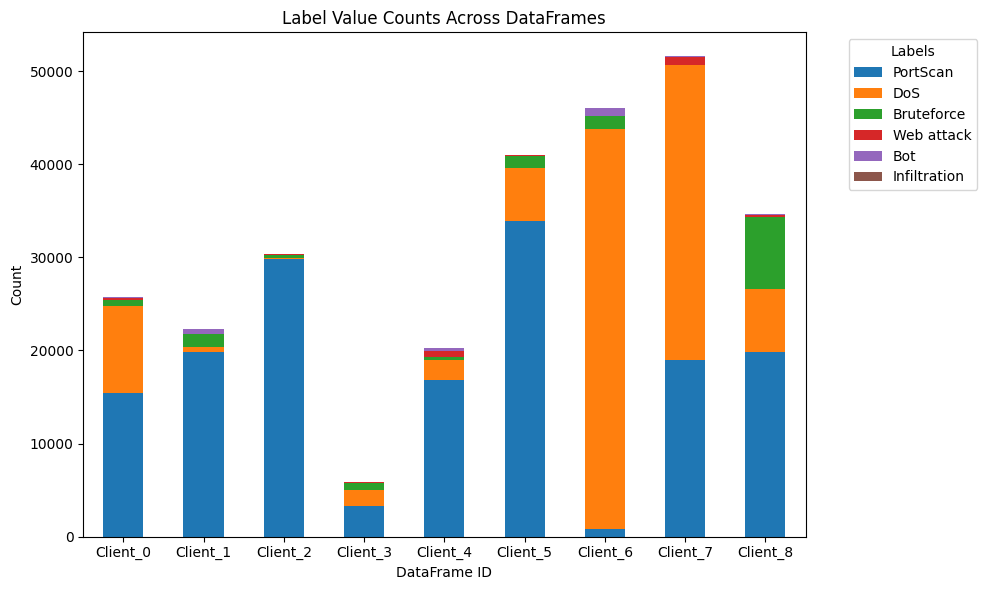

In [77]:
visualize_partitions(attack_partitions)

## **Define Client App**

In [13]:
from flwr.client import Client, ClientApp
from flwr.common.config import unflatten_dict
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Status,
)

class FlowerClient(Client):
    def __init__(
        self,
        train_dmatrix,
        valid_dmatrix,
        num_train,
        num_val,
        num_local_round,
        params,
    ):
        self.train_dmatrix = train_dmatrix
        self.valid_dmatrix = valid_dmatrix
        self.num_train = num_train
        self.num_val = num_val
        self.num_local_round = num_local_round
        self.params = params

    def _local_boost(self, bst_input):
        # Update trees based on local training data.
        for i in range(self.num_local_round):
            bst_input.update(self.train_dmatrix, bst_input.num_boosted_rounds())

        # Bagging: extract the last N=num_local_round trees for sever aggregation
        bst = bst_input[
            bst_input.num_boosted_rounds()
            - self.num_local_round : bst_input.num_boosted_rounds()
        ]

        return bst

    def fit(self, ins: FitIns) -> FitRes:
        global_round = int(ins.config["global_round"])
        if global_round == 1:
            # First round local training
            bst = xgb.train(
                self.params,
                self.train_dmatrix,
                num_boost_round=self.num_local_round,
                evals=[(self.valid_dmatrix, "validate"), (self.train_dmatrix, "train")],
            )
        else:
            bst = xgb.Booster(params=self.params)
            global_model = bytearray(ins.parameters.tensors[0])

            # Load global model into booster
            bst.load_model(global_model)

            # Local training
            bst = self._local_boost(bst)

        # Save model
        local_model = bst.save_raw("json")
        local_model_bytes = bytes(local_model)

        return FitRes(
            status=Status(
                code=Code.OK,
                message="OK",
            ),
            parameters=Parameters(tensor_type="", tensors=[local_model_bytes]),
            num_examples=self.num_train,
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        # Load global model
        bst = xgb.Booster(params=self.params)
        para_b = bytearray(ins.parameters.tensors[0])
        bst.load_model(para_b)

        # Run evaluation
        eval_results = bst.eval_set(
            evals=[(self.valid_dmatrix, "valid")],
            iteration=bst.num_boosted_rounds() - 1,
        )
        mlogloss = round(float(eval_results.split("\t")[1].split(":")[1]), 4)

        return EvaluateRes(
            status=Status(
                code=Code.OK,
                message="OK",
            ),
            loss=0.0,
            num_examples=self.num_val,
            metrics={"mlogloss": mlogloss},
        )

In [14]:
def replace_keys(input_dict, match="-", target="_"):
    """Recursively replace match string with target string in dictionary keys."""
    new_dict = {}
    for key, value in input_dict.items():
        new_key = key.replace(match, target)
        if isinstance(value, dict):
            new_dict[new_key] = replace_keys(value, match, target)
        else:
            new_dict[new_key] = value
    return new_dict

In [15]:
def client_fn(context: Context):
    # Load model and data
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    train_dmatrix, valid_dmatrix,_, num_train, num_val,_ = partition_dataset_supervised(final_df,partition_id,'dirichlet',label_col_num = 3)

    cfg = replace_keys(unflatten_dict(context.run_config))
    num_local_round = cfg["local_epochs"]

    # Return Client instance
    return FlowerClient(
        train_dmatrix,
        valid_dmatrix,
        num_train,
        num_val,
        num_local_round,
        cfg["params"],
    )

## **Define Server App**

In [16]:
from typing import Dict

from flwr.common import Context, Parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig, History
from flwr.server.strategy import FedXgbBagging


def evaluate_metrics_aggregation(eval_metrics):
    """Return an aggregated metric (AUC) for evaluation."""
    total_num = sum([num for num, _ in eval_metrics])
    auc_aggregated = (
        sum([metrics["AUC"] * num for num, metrics in eval_metrics]) / total_num
    )
    metrics_aggregated = {"AUC": auc_aggregated}
    return metrics_aggregated


def config_func(rnd: int) -> Dict[str, str]:
    """Return a configuration with global epochs."""
    config = {
        "global_round": str(rnd),
    }
    return config


def server_fn(context: Context):
    # Read from config
    num_rounds = context.run_config["num-server-rounds"]
    fraction_fit = context.run_config["fraction-fit"]
    fraction_evaluate = context.run_config["fraction-evaluate"]

    # Init an empty Parameter
    parameters = Parameters(tensor_type="", tensors=[])

    # Define strategy
    strategy = FedXgbBagging(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation,
        on_evaluate_config_fn=config_func,
        on_fit_config_fn=config_func,
        initial_parameters=parameters,
    )
    config = ServerConfig(num_rounds=num_rounds)


    return ServerAppComponents(strategy=strategy, config=config)

In [20]:
!git clone --depth=1 https://github.com/adap/flower.git _tmp \
        && mv _tmp/examples/xgboost-quickstart . \
        && rm -rf _tmp \
        && cd xgboost-quickstart

Cloning into '_tmp'...
remote: Enumerating objects: 2768, done.
remote: Counting objects: 100% (2768/2768), done.
remote: Compressing objects: 100% (2241/2241), done.
remote: Total 2768 (delta 613), reused 1745 (delta 322), pack-reused 0 (from 0)
Receiving objects: 100% (2768/2768), 62.39 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (613/613), done.


In [26]:
!pwd

/content


In [27]:
%cd xgboost-quickstart

/content/xgboost-quickstart


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
!pwd

/content/xgboost-quickstart


In [38]:
!pip install -e .

Obtaining file:///content/xgboost-quickstart
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for xgboost_quickstart (pyproject.toml) ... done
  Created wheel for xgboost_quickstart: filename=xgboost_quickstart-1.0.0-py2.py3-none-any.whl size=1138 sha256=0f17eda23e59ba4b5eb489c63dccc7c943de1a23eae6bb125d44b47a8e26c8e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-5h0ejea9/wheels/c7/5c/43/c2648c10abd2e8c3b27d7d3a8f675d0538b1073677eaf74a31
Successfully built xgboost_quickstart
  Attempting uninstall: xgboost_quickstart
    Found existing installation: xgboost_quickstart 1.0.0
    Uninstalling xgboost_quickstart-1.0.0:
      Successfully uninstalled xgboost_quickstart-1.0.0


In [61]:
%cd xgboost-quickstart

/content/xgboost-quickstart


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
!pip install -e .

Obtaining file:///content/xgboost-quickstart
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for xgboost_quickstart (pyproject.toml) ... done
  Created wheel for xgboost_quickstart: filename=xgboost_quickstart-1.0.0-py2.py3-none-any.whl size=1138 sha256=0f17eda23e59ba4b5eb489c63dccc7c943de1a23eae6bb125d44b47a8e26c8e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7q_1olh/wheels/c7/5c/43/c2648c10abd2e8c3b27d7d3a8f675d0538b1073677eaf74a31
Successfully built xgboost_quickstart
  Attempting uninstall: xgboost_quickstart
    Found existing installation: xgboost_quickstart 1.0.0
    Uninstalling xgboost_quickstart-1.0.0:
      Successfully uninstalled xgboost_quickstart-1.0.0


In [73]:
!flwr run .

2025-01-26 12:06:13.210404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 12:06:13.226643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 12:06:13.231615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 12:06:14.400029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading project configuration... 
Success
2025-01-26 12:06:16.546852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been 

In [57]:
%cd ..

/content


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
!zip -r xgb.zip xgboost_quickstart/

  adding: xgboost_quickstart/ (stored 0%)
  adding: xgboost_quickstart/__pycache__/ (stored 0%)
  adding: xgboost_quickstart/__pycache__/client_app.cpython-311.pyc (deflated 52%)
  adding: xgboost_quickstart/__pycache__/task.cpython-311.pyc (deflated 47%)
  adding: xgboost_quickstart/__pycache__/server_app.cpython-311.pyc (deflated 48%)
  adding: xgboost_quickstart/__pycache__/__init__.cpython-311.pyc (deflated 28%)
  adding: xgboost_quickstart/server_app.py (deflated 62%)
  adding: xgboost_quickstart/task.py (deflated 62%)
  adding: xgboost_quickstart/client_app.py (deflated 71%)
  adding: xgboost_quickstart/__init__.py (stored 0%)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Simulated Dataset for Anomaly Detection
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + 1: idx + self.sequence_length + 1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_layers, sequence_length):
        super(TransformerAnomalyDetector, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers
        )
        self.output_layer = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        # Add positional encoding
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer(x, x)  # Transformer encoder-decoder
        x = self.output_layer(x)
        return x

In [ ]:
def train_model(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.unsqueeze(-1), y.unsqueeze(-1)  # Add input_dim as 1
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

In [ ]:
def detect_anomalies(model, dataloader, threshold):
    model.eval()
    anomalies = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.unsqueeze(-1), y.unsqueeze(-1)
            output = model(x)
            reconstruction_error = torch.mean((output - y) ** 2, dim=1).numpy()
            anomalies.append(reconstruction_error > threshold)
    return np.concatenate(anomalies)